# 🧠 Main Project Experiment Notebook
This notebook runs the main continual learning experiment for our controller-based model.

We evaluate controller variants on a sequence of three tasks using multi-phase training:
1. **XOR Shape and Color**
2. **XOR Shape and Width**
3. **XOR Width and Color**

We will track both **task switching performance** and **critical forgetting**, and later compare standard backpropagation against LoRA-based orthogonality-regularized learning.

## 🔧 Setup & Imports
We import core training and experiment infrastructure from `src/`. Additional analysis and visualisation tools will be added as needed.

In [1]:
# === SYSTEM PATH SETUP ===
import sys
from pathlib import Path
import copy

# Set the project root (the directory containing 'src/')
project_root = Path("/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# === STANDARD SCIENTIFIC LIBRARIES ===
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# === CUSTOM LIBRARIES ===
from src.utils.config_handling import create_experiment_config
from src.data.data_generation import DataGenerator
from src.models.experiment_network import ExperimentNetwork
from src.models.model_factory import load_checkpoint_models
from src.training.trainers.StandardTrainer import StandardTrainer
from src.analysis.visualisation import plot_training_analysis, plot_trial_type_comparison, plot_decoding_time, plot_decoding_learning, plot_continual_validation_traces, plot_forgetting_matrix, plot_transfer_onset_latencies
from src.analysis.utils import get_models_activations, identify_trial_types, get_percentile_indices, combine_phase_results, combine_multiple_phase_results
from src.analysis.representations import decode_across_epochs_and_time, compute_forgetting_matrix, compute_transfer_onset_latency
from src.experimenting.experiment_running import Experiment, ExperimentRunner 


# === NOTEBOOK SETUP ===
sns.set_theme(context='notebook')
%config InlineBackend.figure_format = 'retina' 

## Step 1️⃣ : Define and Save the Experiment Configuration

In this section, we create a base configuration dictionary for our experiment using the  `create_experiment_config` utility function. This config includes:

- Temporal structure of trials
- Dataset and task selection
- Model architecture (including controller settings)
- Plasticity options
- Training hyperparameters
- Reproducibility and device settings

The config is saved as a `.yml` file for consistent reproducibility and downstream use.

Overwriting configuration file at /Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/configs/continual_learning_project.yml

Analyzing continual_abstract – None

Design Matrix:


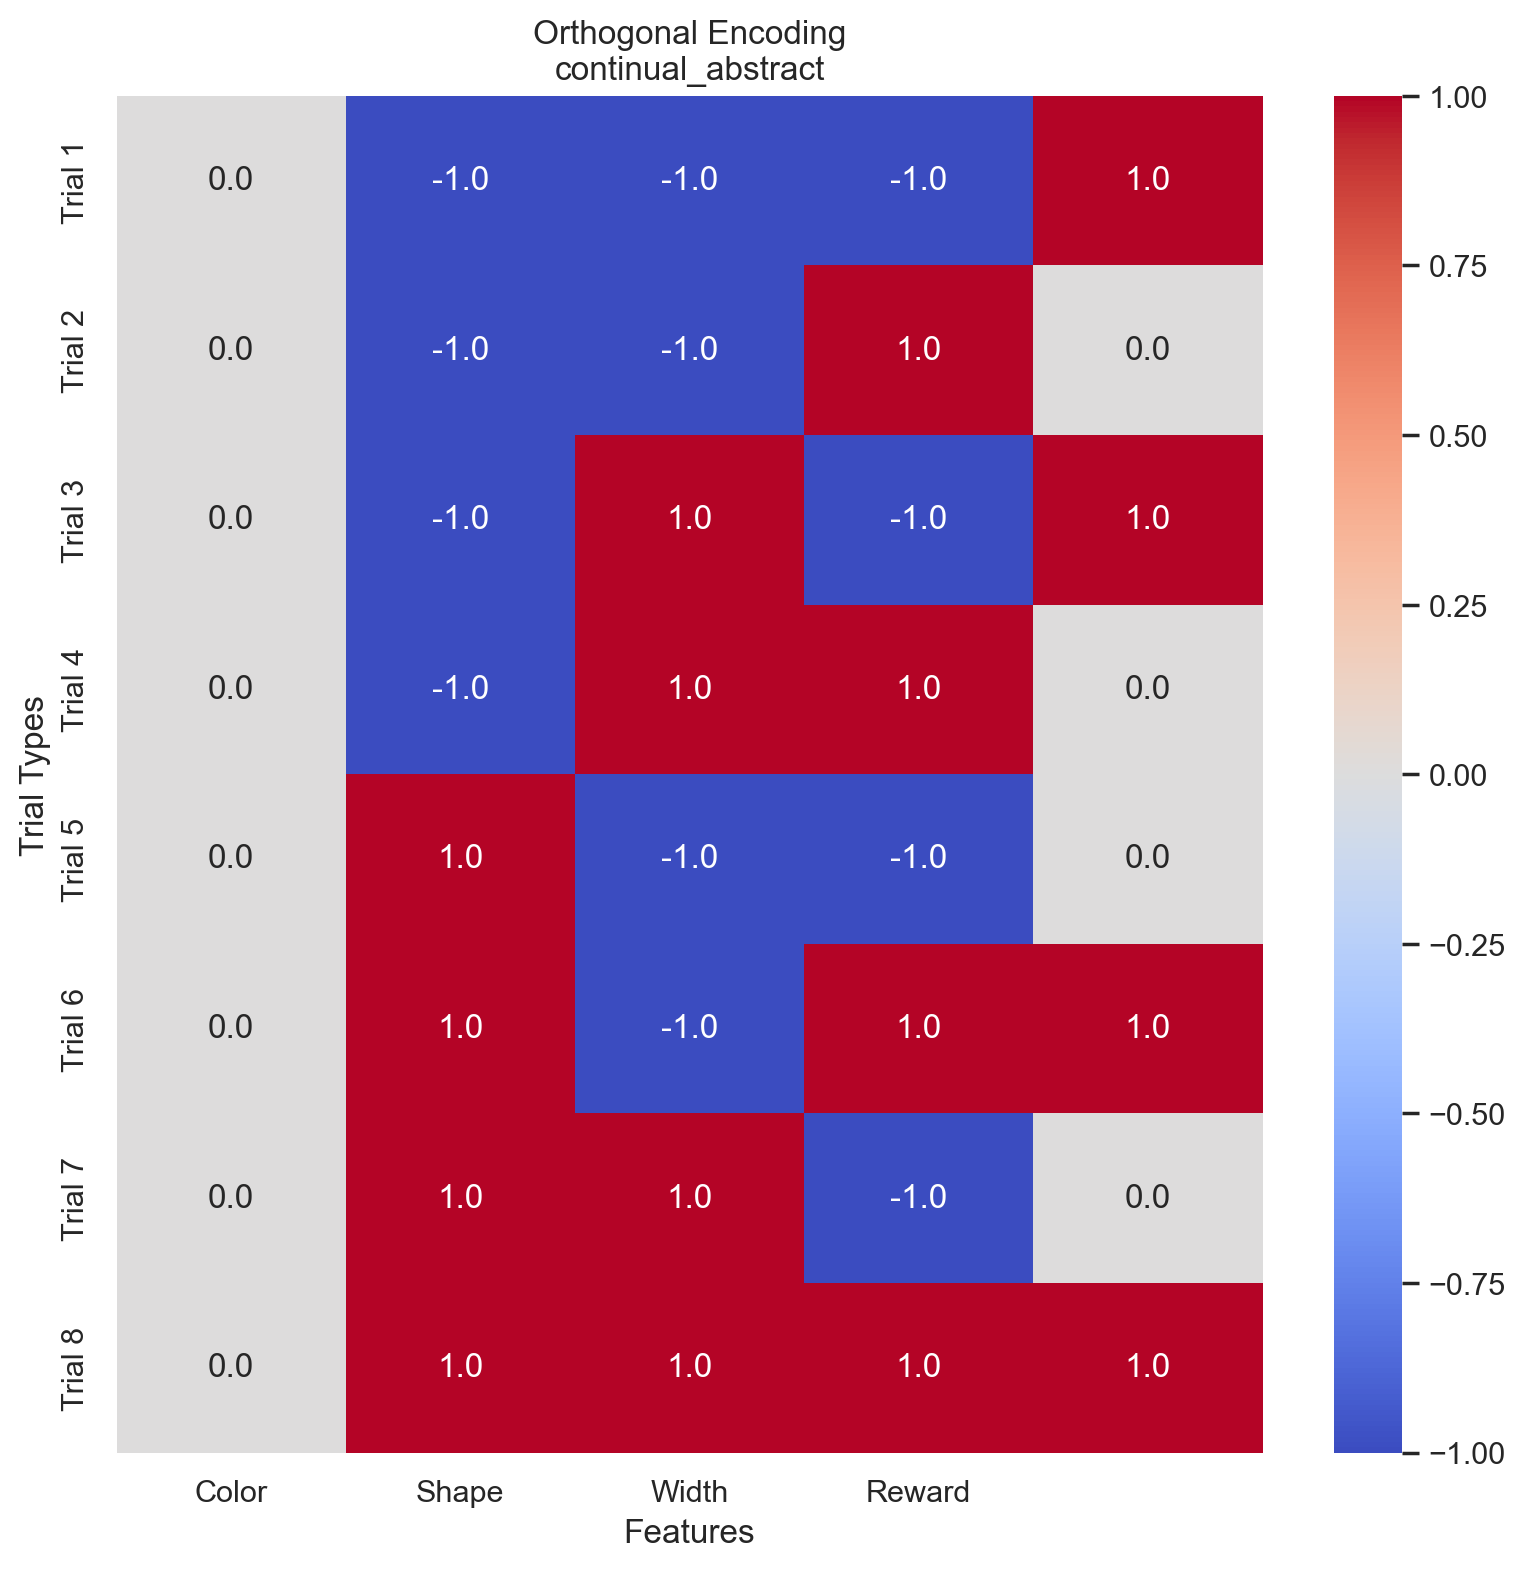


Event Sequence:


/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/src/data/data_generation.py:717: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, alpha=0.3)


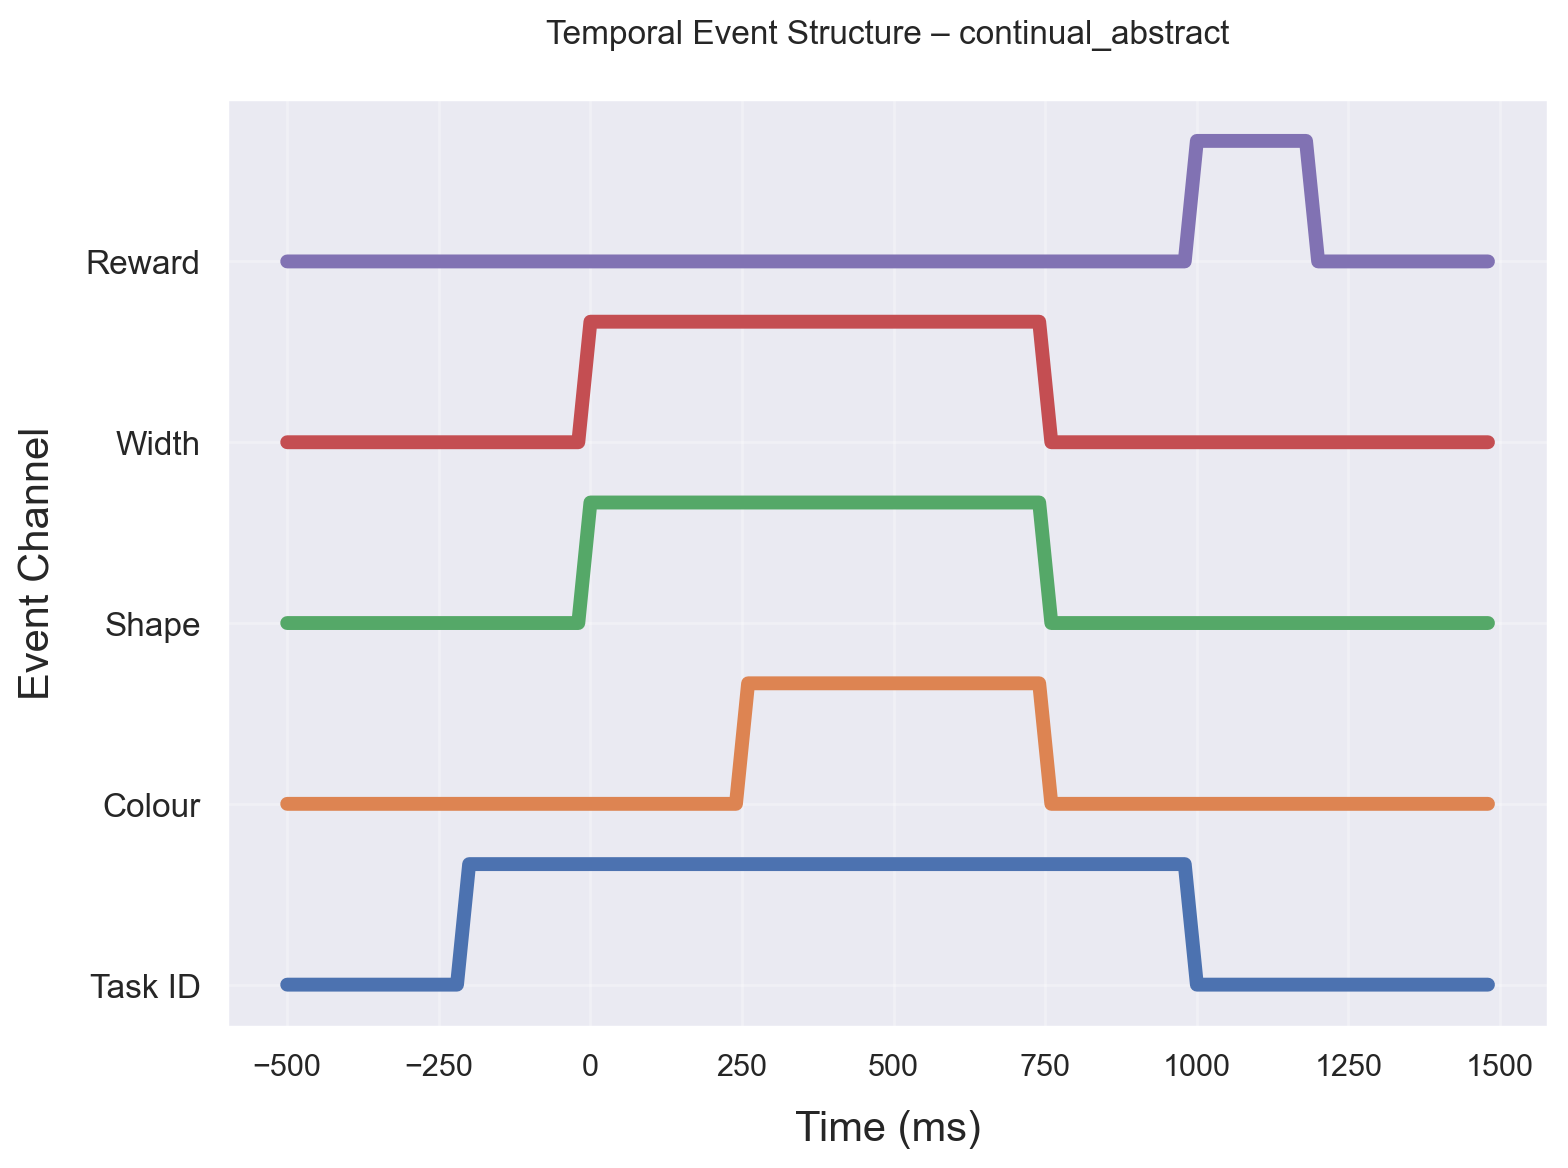


Trial Types:


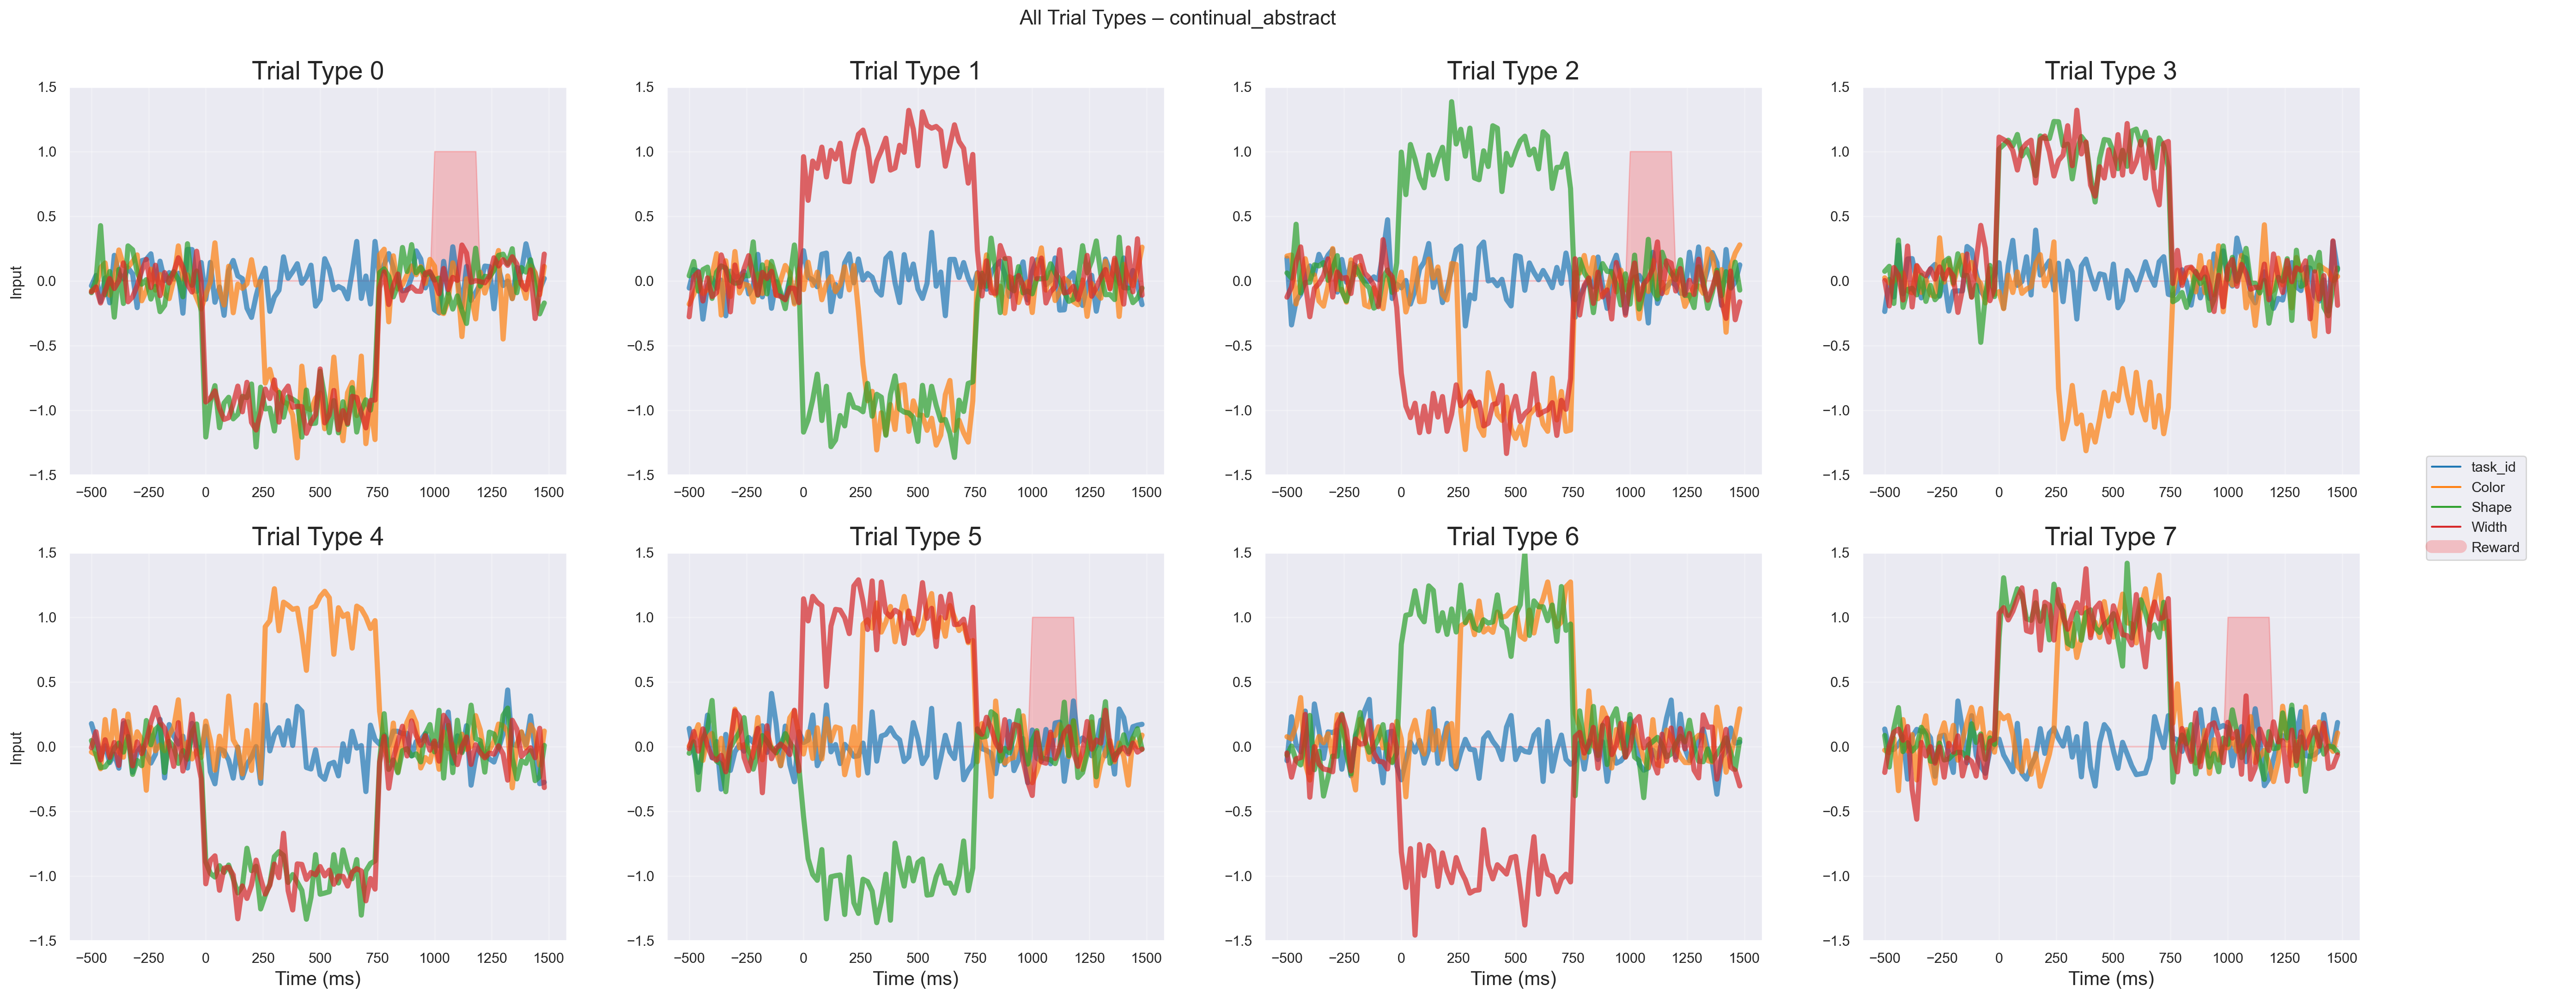

In [2]:
# Set where to save the config
save_path = Path("/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/configs")
config_fname = 'continual_learning_project.yml'
config_path = save_path / config_fname

# Create base config for experiment and save to disk
config = create_experiment_config(
    experiment_name="continual_learning_project",
    save_path=save_path,
    config_fname=config_fname,
    overwrite=True,

    # ---- Trial timing (in ms) ----
    temporal={
        't_min': -500,            # Start time of trial
        't_max': 1500,            # End time of trial
        'dt': 20,                 # Time resolution (ms per step)
        'colour_onset': 250.0,
        'colour_offset': 750.0,
        'shape_onset': 0.0,
        'shape_offset': 750.0,
        'reward_onset': 1000.0,
        'reward_offset': 1200.0  # Reward cue ends
    },

    # ---- Dataset and validation ----
    data={
        'n_trials': 200,                   # Total number of trials
        'input_noise_std': 0.15,             # Gaussian noise added to inputs
        'batch_size': 32,                   # Training batch size
        'num_workers': 0,                   # DataLoader worker threads
        'encoding_mode': 'orthogonal',      # How task features are encoded
        'experiment_type': 'continual_abstract',  # Task family (e.g. XOR, AND)
        'task_indices': [23],               # Which abstract task(s) to use
        'val_indices': {14: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        23: {
                            'colour_onset': 0.0,
                            'colour_offset': 750.0,
                            'shape_onset': 250.0,
                            'shape_offset': 750.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        27: {
                            'colour_onset': 250.0,
                            'colour_offset': 750.0,
                            'shape_onset': 0.0,
                            'shape_offset': 750.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        }, 
                    }
    },

    # ---- Device ----
    hardware={
        'device': 'cpu',                 # Options: 'cpu', 'cuda', 'mps'
        'precision': 'float32',          # Tensor precision
        'deterministic': True            # Force deterministic ops for reproducibility
    },

    # ---- Model config ----
    model={
        'type': 'ExperimentNetwork',     # Dispatches to CCtRNN + controller

        # Learning rule configuration
        'learning_rule': 'lora',  # Can be 'standard_bp' 'lora'.
        'learning_rule_params': {'output_layer': False,
                                 'lambda_orth': 150.0, #
                                 'lora_strength': 1.0, # Scaling for LoRA weights contribution to controller outut
                                 'lora_rank': 1, 
                                 'lora_init_g': 0.1,
                                 'penalty_types': {'basis_overlap': True,
                                                   'weight_overlap': False,
                                                   'signal_overlap': False, 
                                                   'intra_basis_overlap': False,}, 
                                 'concat_past_bases': False ,  # If True, concatenate past LoRA bases instead of adding
                                },    


        # Core RNN parameters (cortical dynamics)
        'network': {
            'input_size': 4,             # 3 input channels (task features)
            'hidden_size': 150,           # Size of cortical recurrent population
            'output_size': 2,            # Binary output (reward / no reward)
            'tau': 50.0,                 # Membrane time constant (ms)
            'dt': 20.0,                  # Integration step (ms)
            'noise_std': 0.3,            # RNN Gaussian noise
            'nonlinearity': 'relu',      # Activation function
            'init_method': 'normal',     # Weight init scheme
            'init_g': 1.25                # Scaling of initial weights
        },

        # Optional random input layer
        'random_input': {
            'enabled': False,            # Whether to use random input expansion layer module
            'size': 30                   # Size of random input layer
        },

        # Cerebellar controller configuration
        'controller': {
            'enabled': True,               # Whether to use controller module
            'type': 'simple',              # Controller class (e.g. simple, bioplausible - in future)
            'controller_hidden_size': 0,  # Hidden layer width (these args assume simple FF controller for now)
            'controller_hidden_n': 0,      # Number of controller hidden layers
            'controller_init_method': 'normal', # Weight init scheme
            'controller_init_g': 0.1,        # Scaling of initial weights
            'nonlinearity': 'relu',        # Nonlinearity for controller hidden layers
            'output_activation': 'relu',   # Output activation (post controller)
            'output_size': 25              # Size of controller input to RNN hidden layer 
        },
    },
 
    # ---- Plasticity ----
    plasticity={
        # Train input → hidden?
        'hidden_plastic': False,             # Train recurrent weights?
        'output_plastic': False,             # Train hidden → output?
        'h2controller_plastic': True,       # Train hidden → controller?
        'controller2h_plastic': False,        # Train controller → hidden?
        'controller_hidden_plastic': False   # Train controller internal weights?
    },

    # ---- Training ----
    training={
        'optimizer': 'Adam',
        'n_epochs': 100,
        'lr_rnn': 0.00075,                    # Learning rate for RNN weights
        'lr_controller': 0.00075,             # Learning rate for controller weights
        'loss_type': 'crossentropy',
        'activations_l2': 0.00,              # L2 penalty on hidden activations
        'weight_decay': 0.002,                # L2 penalty on weights
        'checkpoint_overwrite': True,       # Overwrite previous model?
        'checkpoint_path': "/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/results/experiment_training/model_callbacks/exp_model1.pt",
        'checkpoint_frequency': 1           # Save every N epochs
    },

    # ---- Seeds ----
    reproducibility={
        'run_multiple': True,   # Disable multiple seed runs for now
        'seed': 131,             # Base random seed
        'n_seeds': 1,           # Number of distinct seeds (if run_multiple)
        'seed_increment': 77    # Increment between seeds
    }
)
# Plot the trial setup from the config
exp_generator = DataGenerator(config_path=config_path)
exp_generator.plot_experiment_summary()


## Step 2️⃣ : Define and Train Models in a Continual Learning Setup

In this section, we define a multi-phase training setup to simulate **continual learning**.

We train the same model architecture across three sequential phases, each introducing a new abstract task. 
Throughout, we track model performance on all tasks of interest — enabling analysis of:

- **Task Switching**: How quickly the model acquires a new task
- **Critical Forgetting**: How well previously learned tasks are retained

This is achieved using a structured variant-based runner setup that handles:
- Different model types (e.g. with or without controller)
- Phase-specific task assignments
- Reuse of trained weights across learning phases

In [ ]:
'''
-------------------------------------------------------------------------
Define Model Variants for Continual Learning Across Phases
-------------------------------------------------------------------------
We define a list of model variants for each phase of a continual learning
experiment. Each phase introduces a new abstract task, and models are trained
sequentially with the goal of retaining performance across tasks.

Each variant dictionary specifies:
- A unique model `name` (shared across phases to indicate continuity)
- The current `phase` number (used to track training order)
- Plasticity settings controlling which weights are updated
- Architecture overrides (e.g., controller connectivity)
- Phase-specific training and data settings (e.g., loss penalties, task index)

In this experiment, we train on the following task logic in each phase:
- Phase 1: **Color XOR Shape** → task index 14
- Phase 2: **Color XOR Width** → task index 23
- Phase 3: **Shape XOR Width** → task index 27

Models with the same `name` across phases are treated as the *same model*
progressing through continual learning. The `ExperimentRunner` will load each
variant from its previous checkpoint and continue training.
'''
variants_phase1 = [
    # Model Variant 1: Standard BP Controller
    {
        "name": "standard_controller",
        "phase": 1,
        "temporal" : {
        'colour_onset': 0.0,      # When color cue starts
        'colour_offset': 1000.0,  # When color cue ends
        'shape_onset': 500.0,     # When shape cue starts
        'shape_offset': 1000.0,   # When shape cue ends
        'reward_onset': 1000.0,   # Reward cue starts
        'reward_offset': 1200.0   # Reward cue ends
        },
        "plasticity": {
            "input_plastic": False,
            "hidden_plastic": False,
            "output_plastic": False,
            "h2controller_plastic": True,
            "controller2h_plastic": False,
            "controller_hidden_plastic": False,
        },
        "model": {
            'learning_rule' : 'standard_bp'  # Use standard backpropagation
        },

        "data":{
            'task_indices': [14], 
            'val_indices': {14: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        23: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        27: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                    }                          
        },
    },
    # Model Variant 2: LoRA Controller
    {
        "name": "lora_controller",
        "temporal" : {
        'colour_onset': 0.0,
        'colour_offset': 1000.0,
        'shape_onset': 500.0,
        'shape_offset': 1000.0,
        'reward_onset': 1000.0,
        'reward_offset': 1200.0
        },
        "phase": 1,
        "plasticity": {
            "input_plastic": False,
            "hidden_plastic": False,
            "output_plastic": False,
            "h2controller_plastic": False,
            "controller2h_plastic": False,
            "controller_hidden_plastic": False,
        },
        "model": {
            'learning_rule' : 'lora',  # Use LoRA for controller training
        },
        "data":{
            'task_indices': [14], 
            'val_indices': {14: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        23: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        27: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        }, 
                    }           
        },
    },
]

variants_phase2 = [
        # Model Variant 1: Standard BP Controller
    {
        "name": "standard_controller",
        "phase": 2,
        "temporal" : {
        'colour_onset': 0.0,
        'colour_offset': 1000.0,
        'shape_onset': 500.0,
        'shape_offset': 1000.0,
        'reward_onset': 1000.0,
        'reward_offset': 1200.0
        },
        "plasticity": {
            "input_plastic": False,
            "hidden_plastic": False,
            "output_plastic": False,
            "h2controller_plastic": True,
            "controller2h_plastic": False,
            "controller_hidden_plastic": False,
        },
        "model": {
            'learning_rule' : 'standard_bp',  # Use standard backpropagation
        },
        "data":{
            'task_indices': [23],
            'val_indices': {14: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        23: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        27: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        }, 
                    }                          
        },
    },
    # Model Variant 2: LoRA Controller
    {
        "name": "lora_controller",
        "phase": 2,
        "temporal" : {
        'colour_onset': 0.0,
        'colour_offset': 1000.0,
        'shape_onset': 500.0,
        'shape_offset': 1000.0,
        'reward_onset': 1000.0,
        'reward_offset': 1200.0 # Reward cue ends
        },
        "plasticity": {
            "input_plastic": False,
            "hidden_plastic": False,
            "output_plastic": False,
            "h2controller_plastic": False,
            "controller2h_plastic": False,
            "controller_hidden_plastic": False,
        },
        "model": {
            'learning_rule' : 'lora',  # Use LoRA for controller training
        },
        "data":{
            'task_indices': [23], 
            'val_indices': {14: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        23: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        27: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        }, 
                    }  
        },
    },
]

variants_phase3 = [
    # Model Variant 1: Standard BP Controller
    {
        "name": "standard_controller",
        "phase": 3,
        "temporal" : {
        'colour_onset': 0.0,
        'colour_offset': 1000.0,
        'shape_onset': 500.0,
        'shape_offset': 1000.0,
        'reward_onset': 1000.0,
        'reward_offset': 1200.0
        },
        "plasticity": {
            "input_plastic": False,
            "hidden_plastic": False,
            "output_plastic": False,
            "h2controller_plastic": True,
            "controller2h_plastic": False,
            "controller_hidden_plastic": False,
        },
        "model": {
            'learning_rule' : 'standard_bp',  # Use standard backpropagation
        },
        "data":{
            'task_indices': [27],
            'val_indices': {14: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        23: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        27: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        }, 
                    }                          
        },
    },
    # Model Variant 2: LoRA Controller
    {
        "name": "lora_controller",
        "phase": 3,
        "temporal" : {
        'colour_onset': 0.0,
        'colour_offset': 1000.0,
        'shape_onset': 500.0,
        'shape_offset': 1000.0,
        'reward_onset': 1000.0,
        'reward_offset': 1200.0
        },
        "plasticity": {
            "input_plastic": False,
            "hidden_plastic": False,
            "output_plastic": False,
            "h2controller_plastic": False,
            "controller2h_plastic": False,
            "controller_hidden_plastic": False,
        },
        "model": {
            'learning_rule' : 'lora',  # Use LoRA for controller training
        },

        "data":{
            'task_indices': [27], 
            'val_indices': {14: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        23: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                        27: {
                            'colour_onset': 0.0,
                            'colour_offset': 1000.0,
                            'shape_onset': 500.0,
                            'shape_offset': 1000.0,
                            'reward_onset': 1000.0,
                            'reward_offset': 1200.0
                        },
                    }              
        },
    },
]

# Run the experiments
runner = ExperimentRunner(config_path)

# Run phase 1
runner.run_experiments(variants_phase1, speed=True)
results_phase1 = copy.deepcopy(runner.results)

# Run phase 2 (continuing from phase 1 models)
runner.run_experiments(variants_phase2, speed=True)
results_phase2 = copy.deepcopy(runner.results)

# Run phase 3 (continuing from phase 2 models)
runner.run_experiments(variants_phase3, speed=True)
results_phase3 = runner.results


================ RUNNING: STANDARD_CONTROLLER (PHASE 1) ================
Running experiment 1/1 with seed 131
Setting up validation for task 14 with config: {'temporal': {'t_min': -500, 't_max': 1500, 'dt': 20, 'colour_onset': 0.0, 'colour_offset': 1000.0, 'shape_onset': 500.0, 'shape_offset': 1000.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 'data': {'n_trials': 200, 'input_noise_std': 0.15, 'batch_size': 32, 'num_workers': 0, 'encoding_mode': 'orthogonal', 'experiment_type': 'continual_abstract', 'task_indices': [14], 'val_indices': {14: {'colour_onset': 0.0, 'colour_offset': 1000.0, 'shape_onset': 500.0, 'shape_offset': 1000.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 23: {'colour_onset': 0.0, 'colour_offset': 750.0, 'shape_onset': 250.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 27: {'colour_onset': 250.0, 'colour_offset': 750.0, 'shape_onset': 0.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}}}, 'hardware'

Training:   1%|          | 1/100 [00:01<01:23,  1.19it/s, loss= 0.4251  acc= 0.93  ]/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/src/training/callbacks.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an i


================ RUNNING: LORA_CONTROLLER (PHASE 1) ================
Running experiment 1/1 with seed 131
Trainer initialized with config: {'temporal': {'t_min': -500, 't_max': 1500, 'dt': 20, 'colour_onset': 0.0, 'colour_offset': 1000.0, 'shape_onset': 500.0, 'shape_offset': 1000.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 'data': {'n_trials': 200, 'input_noise_std': 0.15, 'batch_size': 32, 'num_workers': 0, 'encoding_mode': 'orthogonal', 'experiment_type': 'continual_abstract', 'task_indices': [14], 'val_indices': {14: {'colour_onset': 0.0, 'colour_offset': 1000.0, 'shape_onset': 500.0, 'shape_offset': 1000.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 23: {'colour_onset': 0.0, 'colour_offset': 750.0, 'shape_onset': 250.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 27: {'colour_onset': 250.0, 'colour_offset': 750.0, 'shape_onset': 0.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}}}, 'hardware': {'device': 'cpu'

Training: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s, loss= 0.1526  orth= 0.0000  acc= 0.98  prev= 0.0000  curr= 1.3119]



================ RUNNING: STANDARD_CONTROLLER (PHASE 2) ================
Running experiment 1/1 with seed 131
Setting up validation for task 14 with config: {'temporal': {'t_min': -500, 't_max': 1500, 'dt': 20, 'colour_onset': 0.0, 'colour_offset': 1000.0, 'shape_onset': 500.0, 'shape_offset': 1000.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 'data': {'n_trials': 200, 'input_noise_std': 0.15, 'batch_size': 32, 'num_workers': 0, 'encoding_mode': 'orthogonal', 'experiment_type': 'continual_abstract', 'task_indices': [14], 'val_indices': {14: {'colour_onset': 0.0, 'colour_offset': 1000.0, 'shape_onset': 500.0, 'shape_offset': 1000.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 23: {'colour_onset': 0.0, 'colour_offset': 750.0, 'shape_onset': 250.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 27: {'colour_onset': 250.0, 'colour_offset': 750.0, 'shape_onset': 0.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}}}, 'hardware'

Training: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s, loss= 0.0001  acc= 1.00  ]



================ RUNNING: LORA_CONTROLLER (PHASE 2) ================
Running experiment 1/1 with seed 131
Trainer initialized with config: {'temporal': {'t_min': -500, 't_max': 1500, 'dt': 20, 'colour_onset': 0.0, 'colour_offset': 750.0, 'shape_onset': 250.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 'data': {'n_trials': 200, 'input_noise_std': 0.15, 'batch_size': 32, 'num_workers': 0, 'encoding_mode': 'orthogonal', 'experiment_type': 'continual_abstract', 'task_indices': [23], 'val_indices': {14: {'colour_onset': 0.0, 'colour_offset': 1000.0, 'shape_onset': 500.0, 'shape_offset': 1000.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 23: {'colour_onset': 0.0, 'colour_offset': 750.0, 'shape_onset': 250.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 27: {'colour_onset': 250.0, 'colour_offset': 750.0, 'shape_onset': 0.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}}}, 'hardware': {'device': 'cpu', 

Training: 100%|██████████| 100/100 [01:25<00:00,  1.18it/s, loss= 0.3573  orth= 0.0000  acc= 0.88  prev= 1.3400  curr= 0.4202]



================ RUNNING: STANDARD_CONTROLLER (PHASE 3) ================
Running experiment 1/1 with seed 131
Setting up validation for task 14 with config: {'temporal': {'t_min': -500, 't_max': 1500, 'dt': 20, 'colour_onset': 0.0, 'colour_offset': 1000.0, 'shape_onset': 500.0, 'shape_offset': 1000.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 'data': {'n_trials': 200, 'input_noise_std': 0.15, 'batch_size': 32, 'num_workers': 0, 'encoding_mode': 'orthogonal', 'experiment_type': 'continual_abstract', 'task_indices': [14], 'val_indices': {14: {'colour_onset': 0.0, 'colour_offset': 1000.0, 'shape_onset': 500.0, 'shape_offset': 1000.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 23: {'colour_onset': 0.0, 'colour_offset': 750.0, 'shape_onset': 250.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 27: {'colour_onset': 250.0, 'colour_offset': 750.0, 'shape_onset': 0.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}}}, 'hardware'

Training: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: LORA_CONTROLLER (PHASE 3) ================
Running experiment 1/1 with seed 131
Trainer initialized with config: {'temporal': {'t_min': -500, 't_max': 1500, 'dt': 20, 'colour_onset': 250.0, 'colour_offset': 750.0, 'shape_onset': 0.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 'data': {'n_trials': 200, 'input_noise_std': 0.15, 'batch_size': 32, 'num_workers': 0, 'encoding_mode': 'orthogonal', 'experiment_type': 'continual_abstract', 'task_indices': [27], 'val_indices': {14: {'colour_onset': 0.0, 'colour_offset': 1000.0, 'shape_onset': 500.0, 'shape_offset': 1000.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 23: {'colour_onset': 0.0, 'colour_offset': 750.0, 'shape_onset': 250.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}, 27: {'colour_onset': 250.0, 'colour_offset': 750.0, 'shape_onset': 0.0, 'shape_offset': 750.0, 'reward_onset': 1000.0, 'reward_offset': 1200.0}}}, 'hardware': {'device': 'cpu', 

Training: 100%|██████████| 100/100 [01:34<00:00,  1.05it/s, loss= 0.6513  orth= 0.0002  acc= 0.64  prev= 1.8719  curr= 0.4657]


## Step 3️⃣ : Analyze Critical Forgetting and Task Switching Performance

In this section, we evaluate how well each model retains and generalizes task knowledge across phases.  
We use the validation task indices defined in the config to assess performance on:

- Phase 1 Task: Color XOR Shape (task 14)  
- Phase 2 Task: Color XOR Width (task 23)  
- Phase 3 Task: Shape XOR Width (task 27)  

The goal is to visualize how performance evolves over time, both during initial learning and across tasks,  
and to assess the extent of interference, retention, and forward transfer throughout training.


In [4]:
# Concatenate results across phases
results_by_phase = [results_phase1, results_phase2, results_phase3]
combined_results = combine_multiple_phase_results(results_by_phase)

# Define task descriptions for analysis plots
task_descriptions = {
    0: "Colour",
    9: "Shape",
    20: "Width",
    14: "Colour XOR Shape",
    23: "Colour XOR Width",
    27: "Shape XOR Width"
}

Combining results for variant: standard_controller
Combining results for variant: lora_controller
Combining results for variant: standard_controller
Combining results for variant: lora_controller


### 3.1 🔁 General Training Analysis


#### Standard BP

/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/src/analysis/visualisation.py:271: RuntimeWarning: Zero initial gradient in layer output. Likely frozen.
  warnings.warn(f"Zero initial gradient in layer {name}. Likely frozen.", RuntimeWarning)
/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/src/analysis/visualisation.py:271: RuntimeWarning: Zero initial gradient in layer input2h. Likely frozen.
  warnings.warn(f"Zero initial gradient in layer {name}. Likely frozen.", RuntimeWarning)
/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/src/analysis/visualisation.py:271: RuntimeWarning: Zero initial gradient in layer h2h. Likely frozen.
  warnings.warn(f"Zero initial gradient in layer {name}. Likely frozen.", RuntimeWarning)
/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/src/analysis/visualisation.py:271: RuntimeWarning: Zero initial gradient in layer control

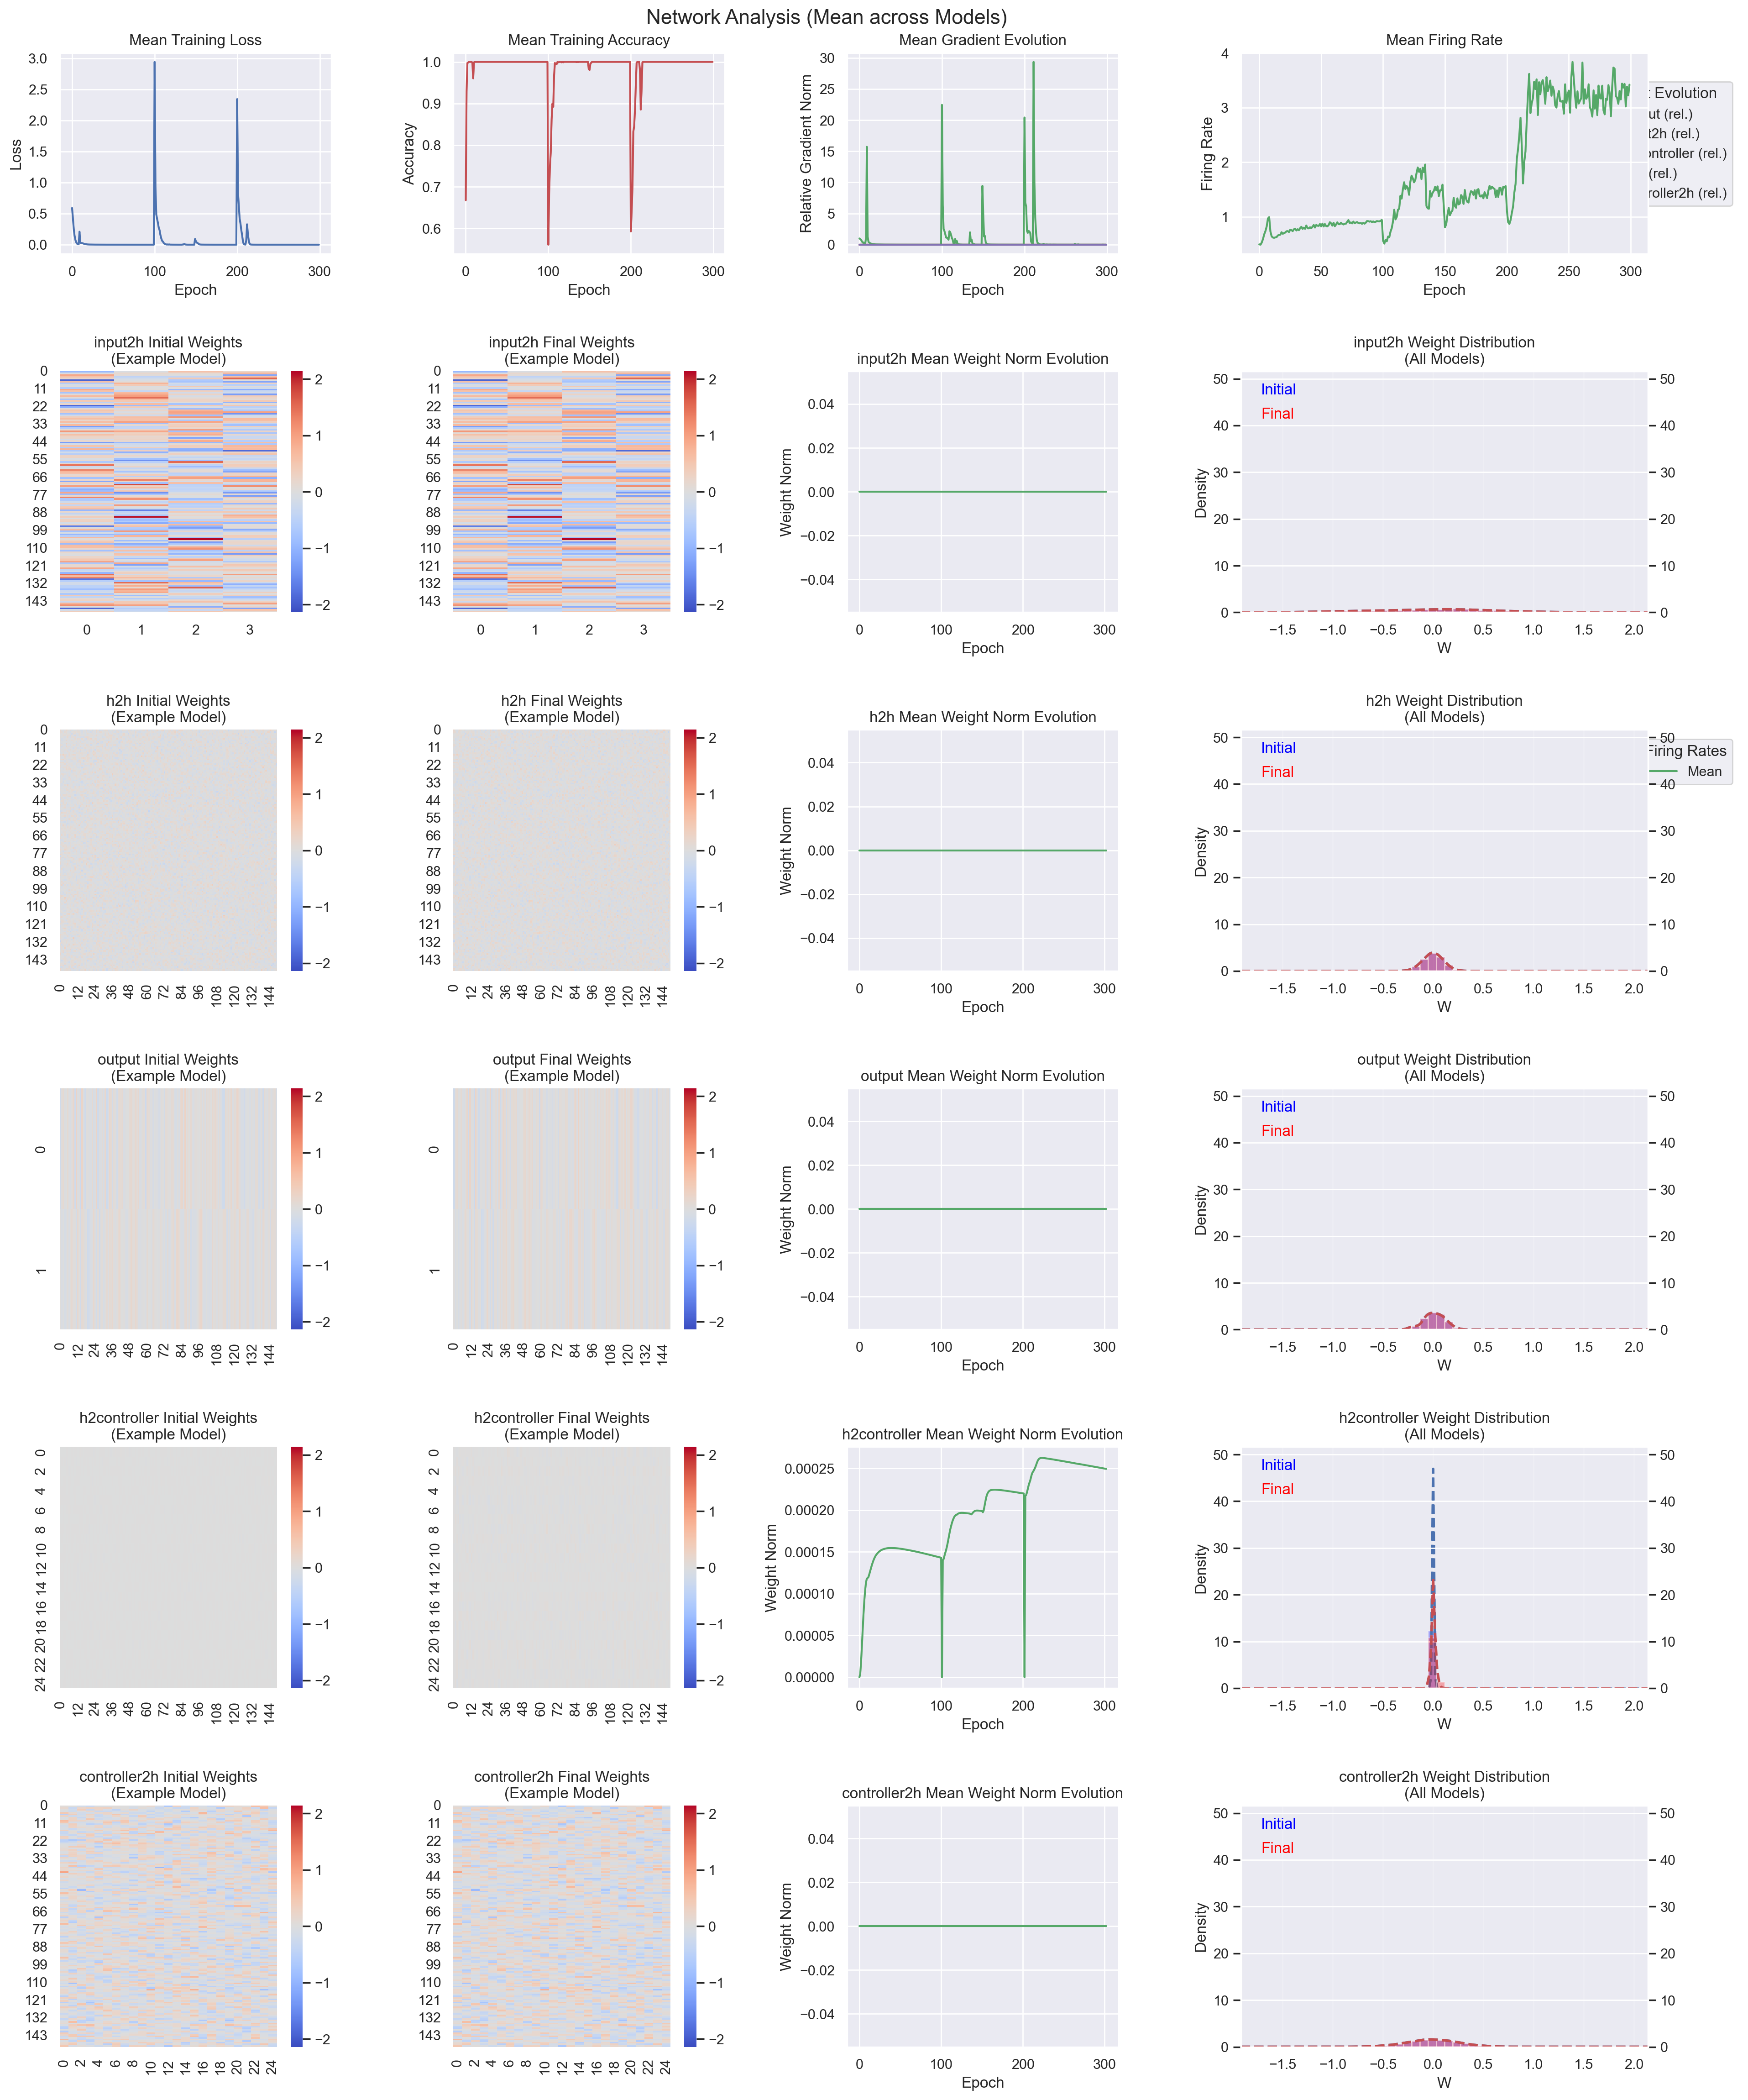


Weight Norm Summary (Mean ± SEM across models):

input2h:
Initial Norm: 15.6142 ± 0.0000
Final Norm: 15.6142 ± 0.0000
Norm Change: 0.0000 ± 0.0000
Relative Change: 0.00% ± 0.00%

h2h:
Initial Norm: 15.3189 ± 0.0000
Final Norm: 15.3189 ± 0.0000
Norm Change: 0.0000 ± 0.0000
Relative Change: 0.00% ± 0.00%

output:
Initial Norm: 1.7931 ± 0.0000
Final Norm: 1.7931 ± 0.0000
Norm Change: 0.0000 ± 0.0000
Relative Change: 0.00% ± 0.00%

h2controller:
Initial Norm: 0.4969 ± 0.0000
Final Norm: 1.4319 ± 0.0000
Norm Change: 0.9351 ± 0.0000
Relative Change: 188.19% ± 0.00%

controller2h:
Initial Norm: 15.3869 ± 0.0000
Final Norm: 15.3869 ± 0.0000
Norm Change: 0.0000 ± 0.0000
Relative Change: 0.00% ± 0.00%

Firing Rate Summary (Mean ± SEM across models):
Initial Mean Rate: 0.4951 ± 0.0000
Final Mean Rate: 3.4217 ± 0.0000
Mean Rate Change: 2.9265 ± 0.0000
Rate Range: [0.4889 ± 0.0000, 3.8395 ± 0.0000]


In [5]:
## General training analysis

# Plot training analysis and decoding results
plot_training_analysis(combined_results['standard_controller']['training_results'])

# plot_decoding_learning(
#     combined_results['controlled_rnn']['decoding_scores'],
#     task_descriptions=task_descriptions,
#     fig_title="Decoding over learning")

# plot_decoding_learning(
#     combined_results['controlled_rnn']['xgen_decoding_scores'],
#     task_descriptions=task_descriptions,
#     fig_title="Cross-generalised decoding over learning")

In [6]:
# data_generator = DataGenerator(config_path=config_path)
# plot_trial_type_comparison(data_generator, runner.trained_models['standard_controller_seed27'], config['hardware']['device'])

#### LoRA

/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/src/analysis/visualisation.py:271: RuntimeWarning: Zero initial gradient in layer output. Likely frozen.
  warnings.warn(f"Zero initial gradient in layer {name}. Likely frozen.", RuntimeWarning)
/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/src/analysis/visualisation.py:271: RuntimeWarning: Zero initial gradient in layer input2h. Likely frozen.
  warnings.warn(f"Zero initial gradient in layer {name}. Likely frozen.", RuntimeWarning)
/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/src/analysis/visualisation.py:271: RuntimeWarning: Zero initial gradient in layer LoRACtrl_curr_inpt_basis. Likely frozen.
  warnings.warn(f"Zero initial gradient in layer {name}. Likely frozen.", RuntimeWarning)
/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/src/analysis/visualisation.py:271: RuntimeWarning: Zero initial grad

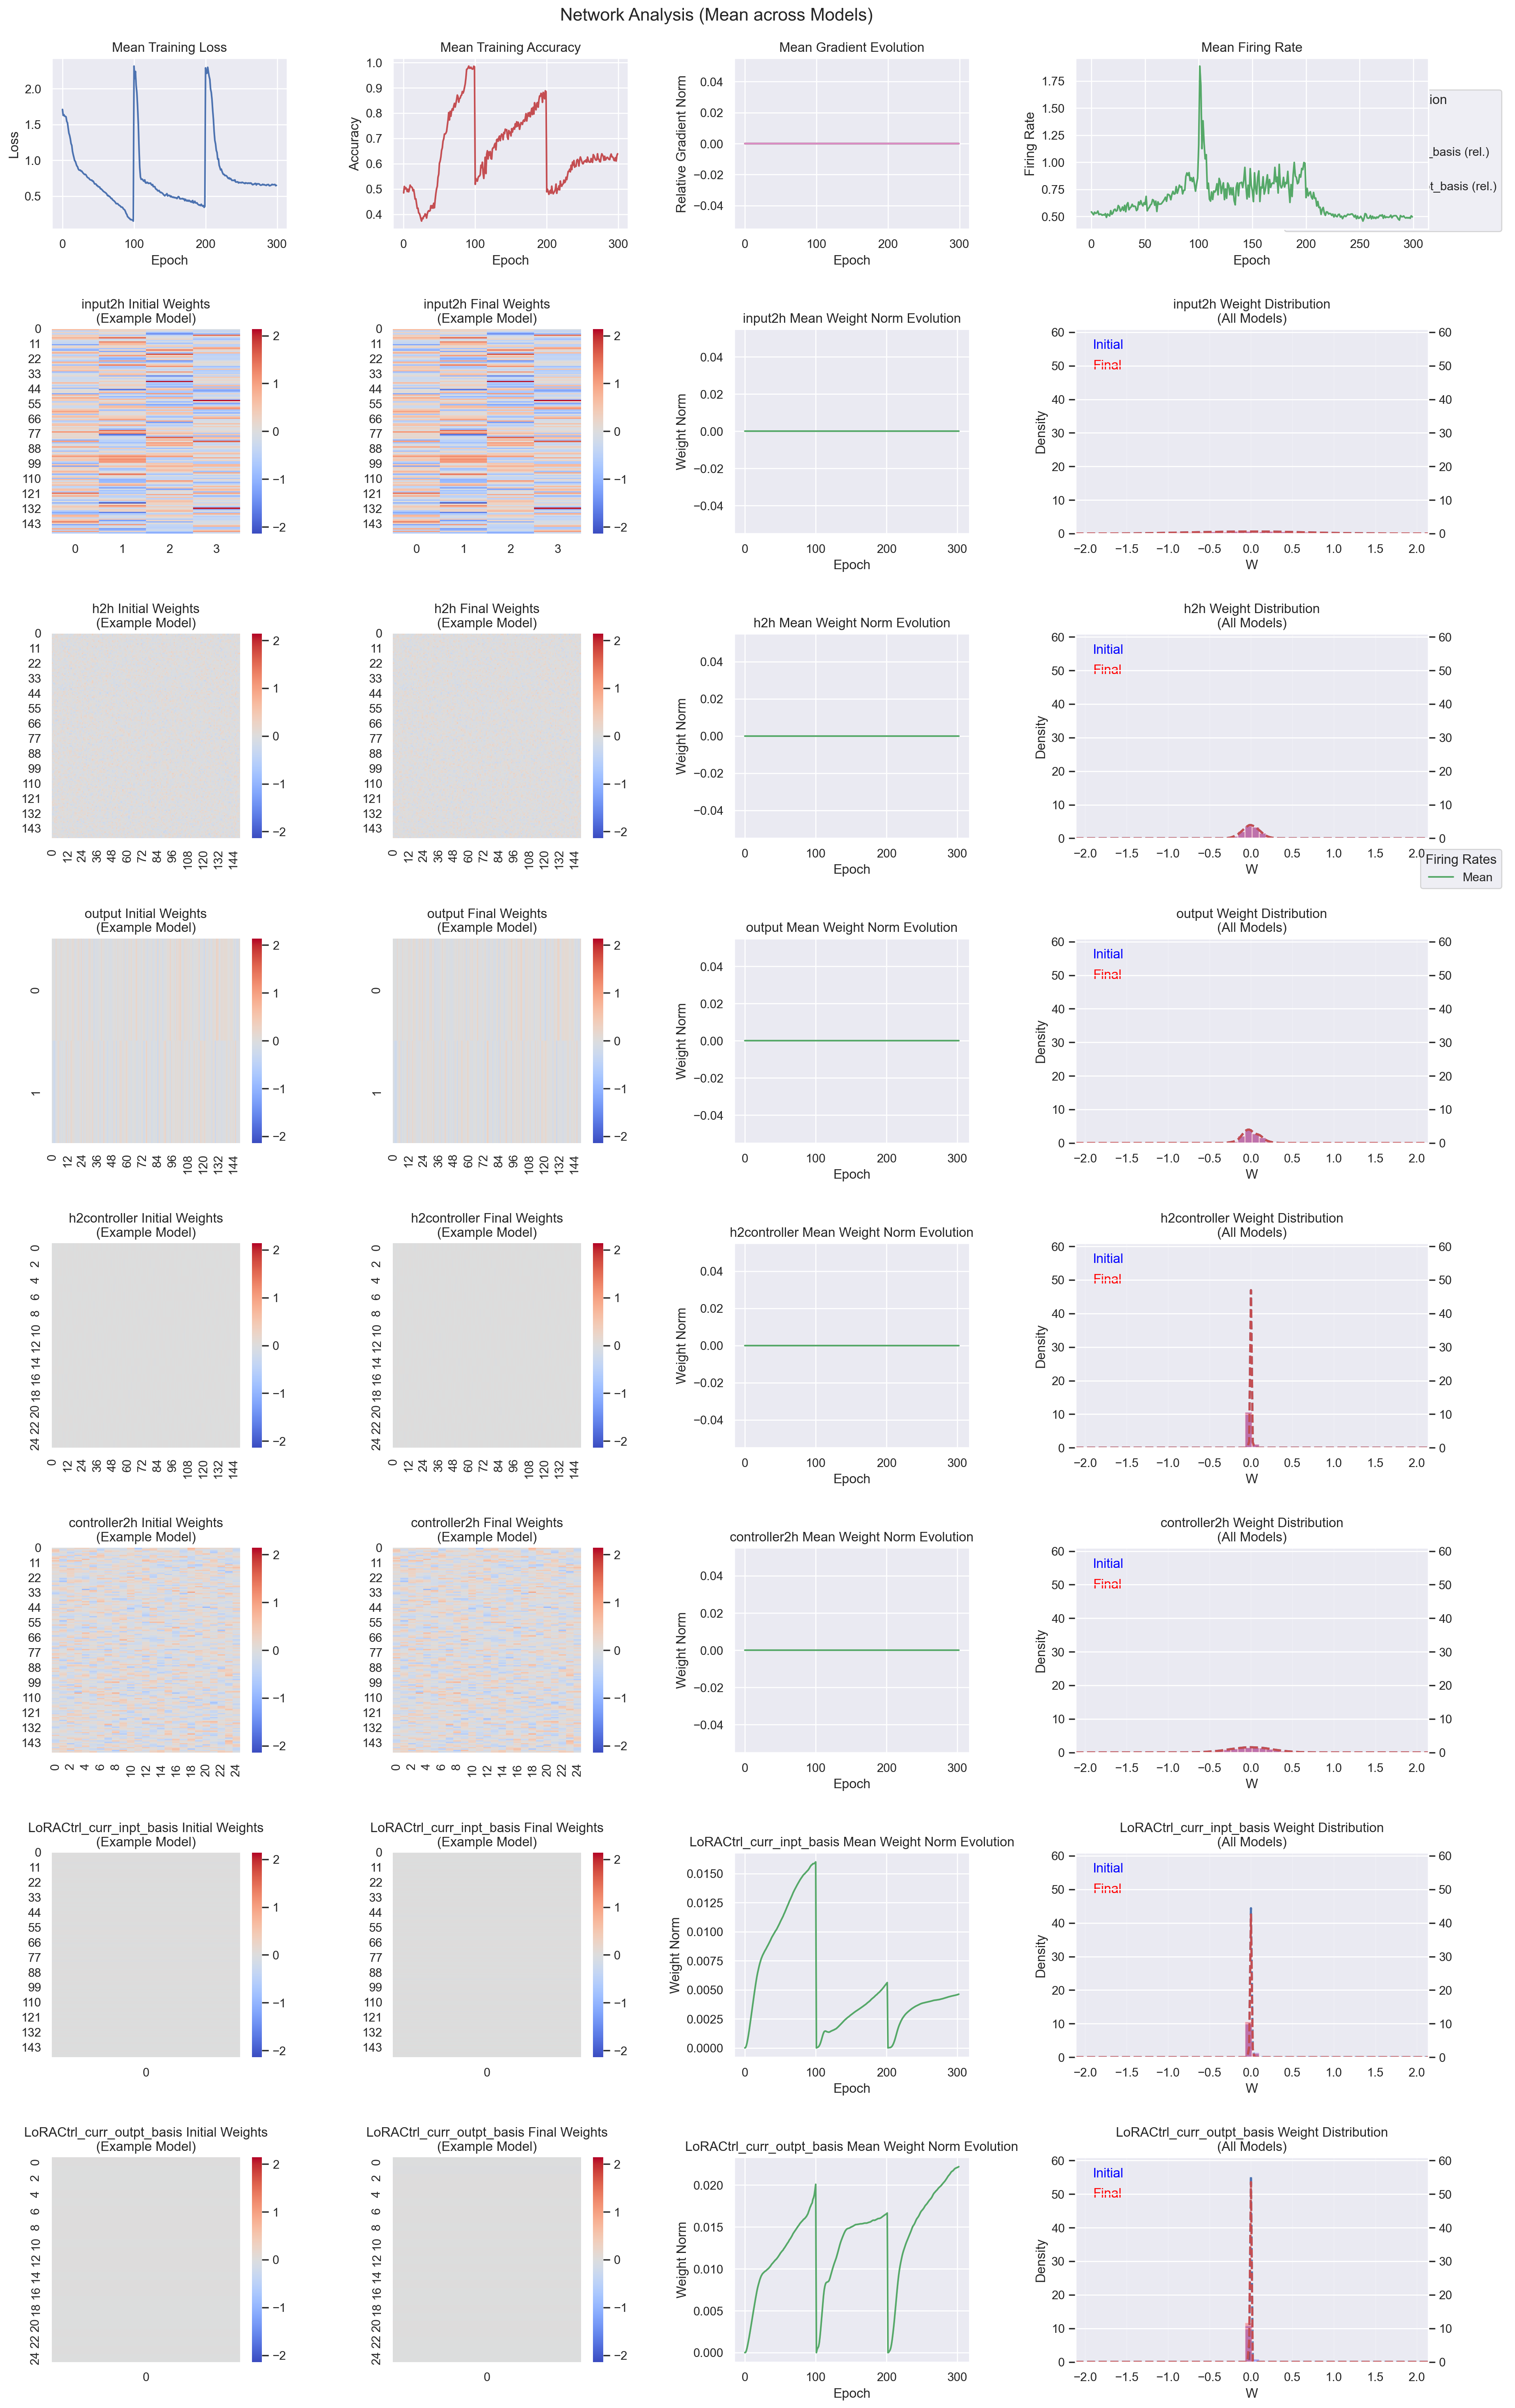


Weight Norm Summary (Mean ± SEM across models):

input2h:
Initial Norm: 15.5012 ± 0.0000
Final Norm: 15.5012 ± 0.0000
Norm Change: 0.0000 ± 0.0000
Relative Change: 0.00% ± 0.00%

h2h:
Initial Norm: 15.2707 ± 0.0000
Final Norm: 15.2707 ± 0.0000
Norm Change: 0.0000 ± 0.0000
Relative Change: 0.00% ± 0.00%

output:
Initial Norm: 1.7270 ± 0.0000
Final Norm: 1.7270 ± 0.0000
Norm Change: 0.0000 ± 0.0000
Relative Change: 0.00% ± 0.00%

h2controller:
Initial Norm: 0.4949 ± 0.0000
Final Norm: 0.4949 ± 0.0000
Norm Change: 0.0000 ± 0.0000
Relative Change: 0.00% ± 0.00%

controller2h:
Initial Norm: 15.3735 ± 0.0000
Final Norm: 15.3735 ± 0.0000
Norm Change: 0.0000 ± 0.0000
Relative Change: 0.00% ± 0.00%

LoRACtrl_curr_inpt_basis:
Initial Norm: 0.1011 ± 0.0000
Final Norm: 0.1051 ± 0.0000
Norm Change: 0.0041 ± 0.0000
Relative Change: 4.01% ± 0.00%

LoRACtrl_curr_outpt_basis:
Initial Norm: 0.0332 ± 0.0000
Final Norm: 0.0384 ± 0.0000
Norm Change: 0.0052 ± 0.0000
Relative Change: 15.73% ± 0.00%

Firing 

In [7]:
## General training analysis

# Plot training analysis and decoding results
plot_training_analysis(combined_results['lora_controller']['training_results'])

# plot_decoding_learning(
#     combined_results['controlled_rnn']['decoding_scores'],
#     task_descriptions=task_descriptions,
#     fig_title="Decoding over learning")

# plot_decoding_learning(
#     combined_results['controlled_rnn']['xgen_decoding_scores'],
#     task_descriptions=task_descriptions,
#     fig_title="Cross-generalised decoding over learning")

In [8]:
# data_generator = DataGenerator(config_path=config_path)
# plot_trial_type_comparison(data_generator, runner.trained_models['lora_controller_seed30'], config['hardware']['device'])

### 3.2 🔁 Critical Forgetting: How Much Do Tasks Get Overwritten?

We quantify how much previously learned tasks are forgotten across phases of training.

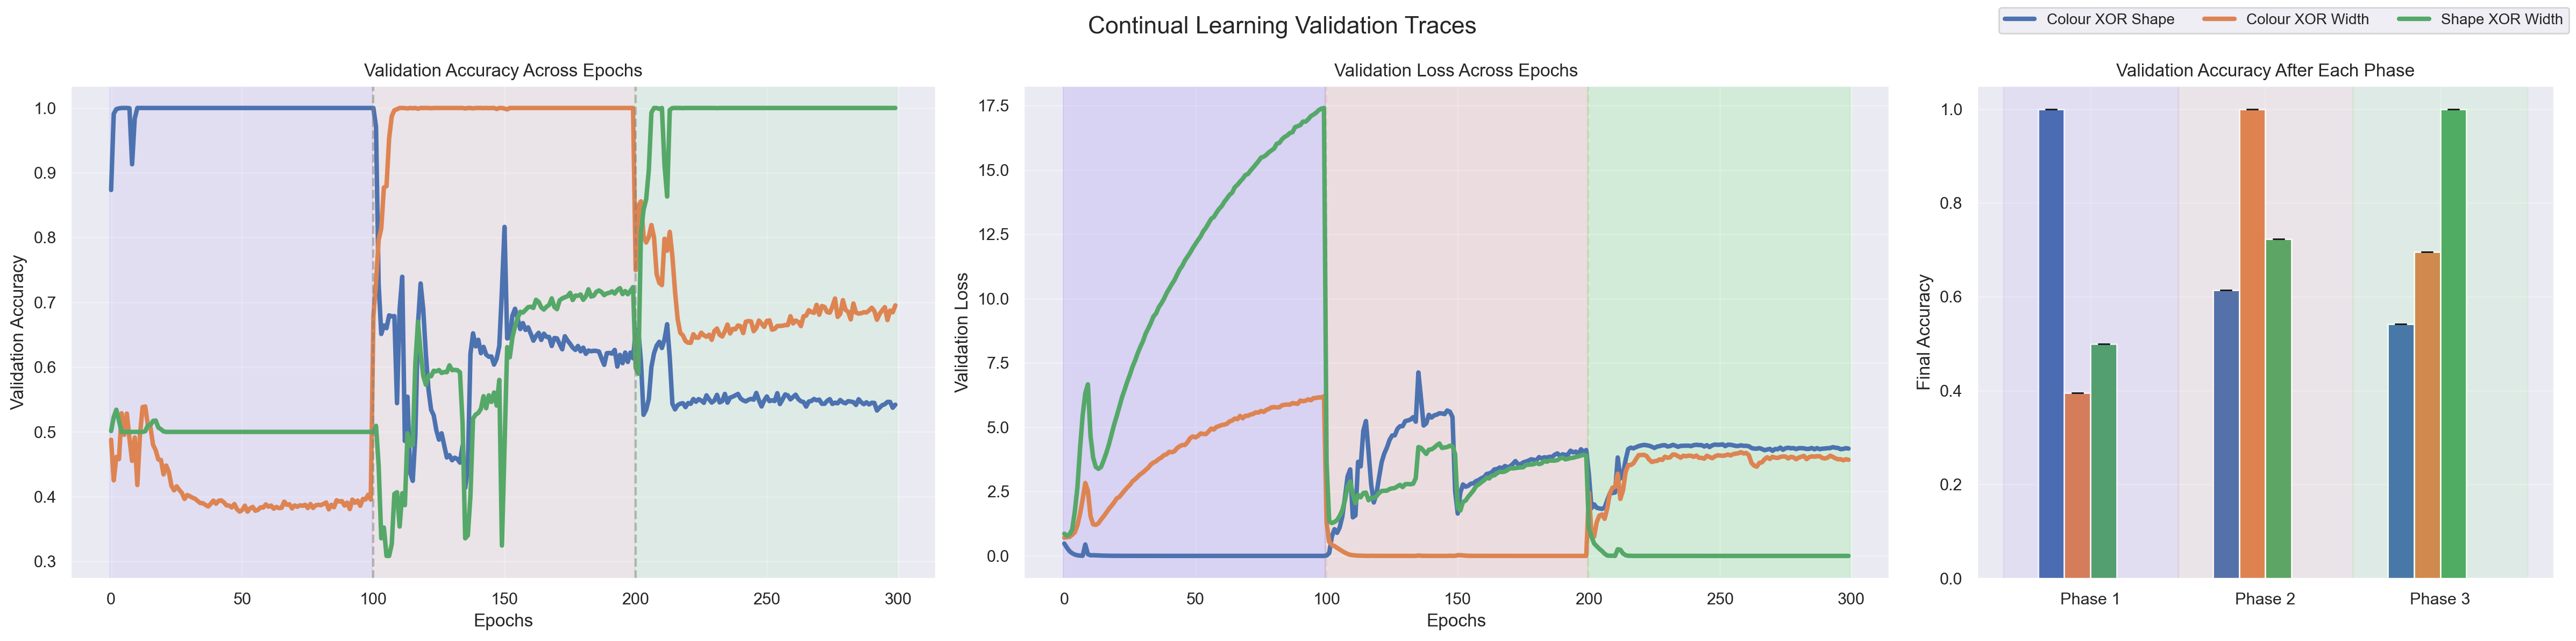

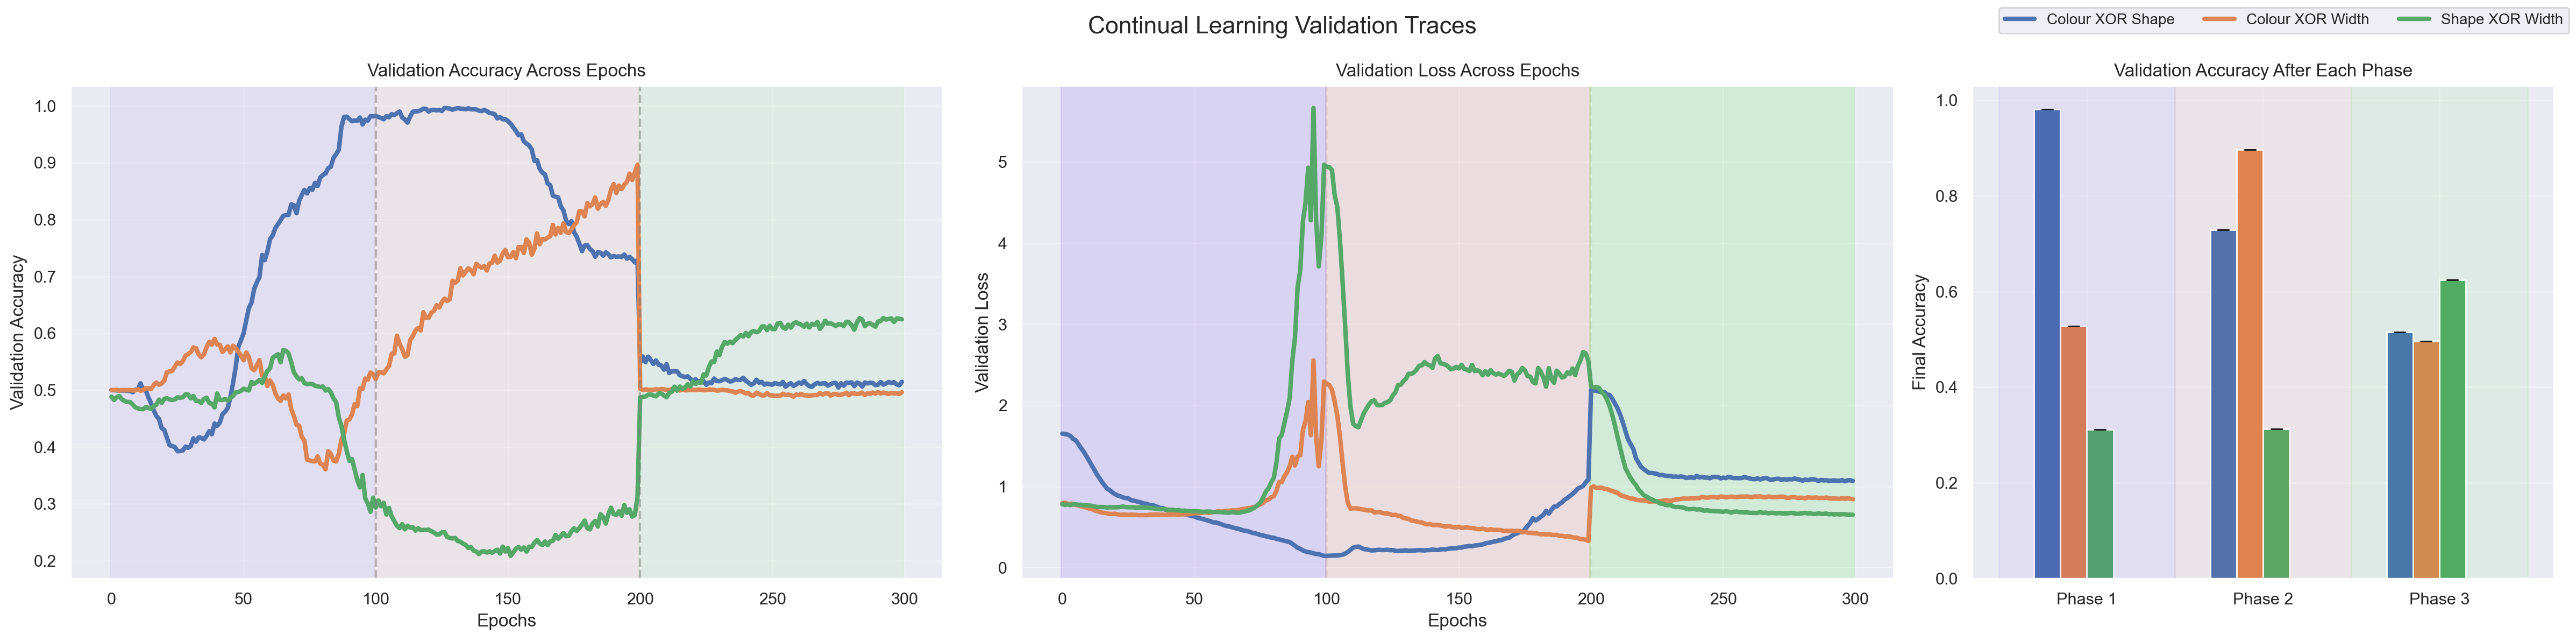

In [9]:
# Plot continual learning traces
task_sequence = [[14], [23], [27]]
plot_continual_validation_traces(
    results=combined_results['standard_controller'],
    task_sequence=task_sequence,
    task_descriptions=task_descriptions)

task_sequence = [[14], [23], [27]]
plot_continual_validation_traces(
    results=combined_results['lora_controller'],
    task_sequence=task_sequence,
    task_descriptions=task_descriptions)

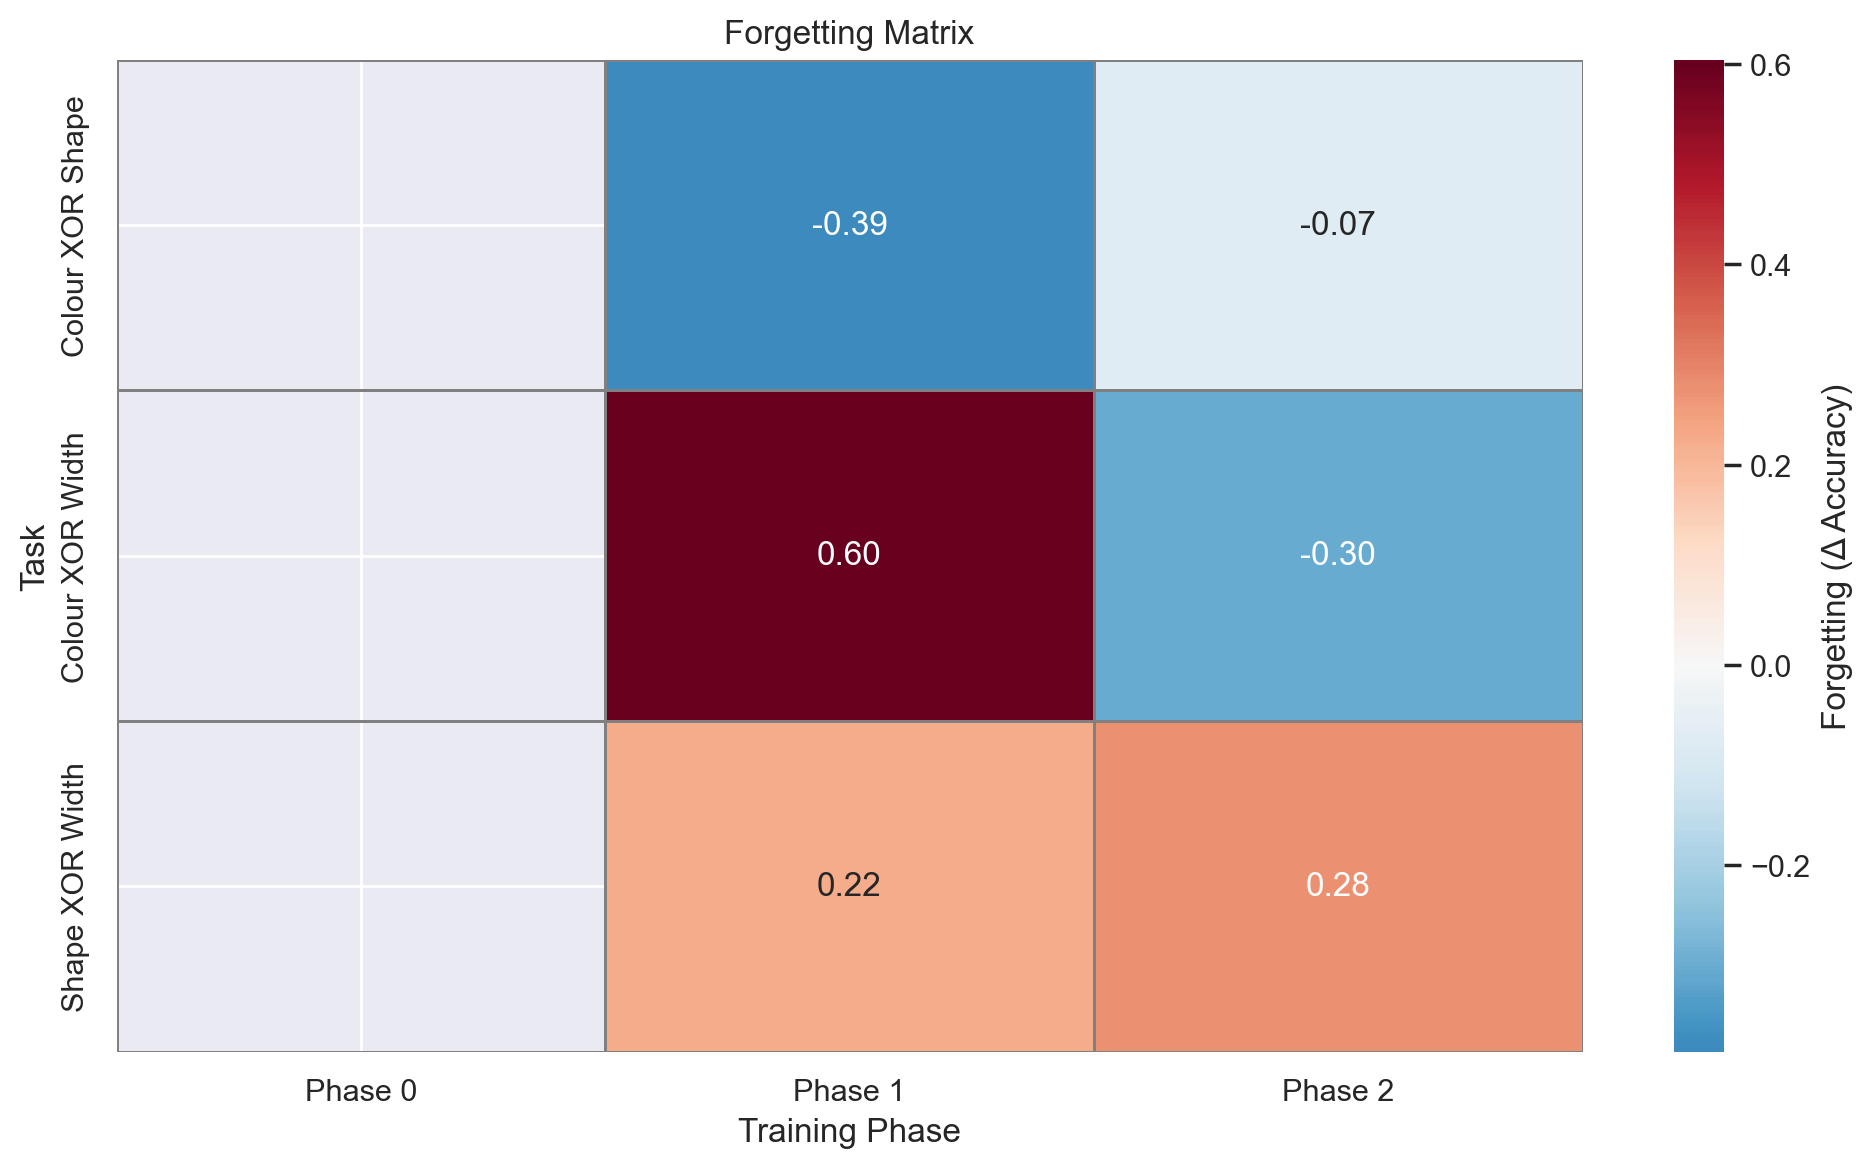

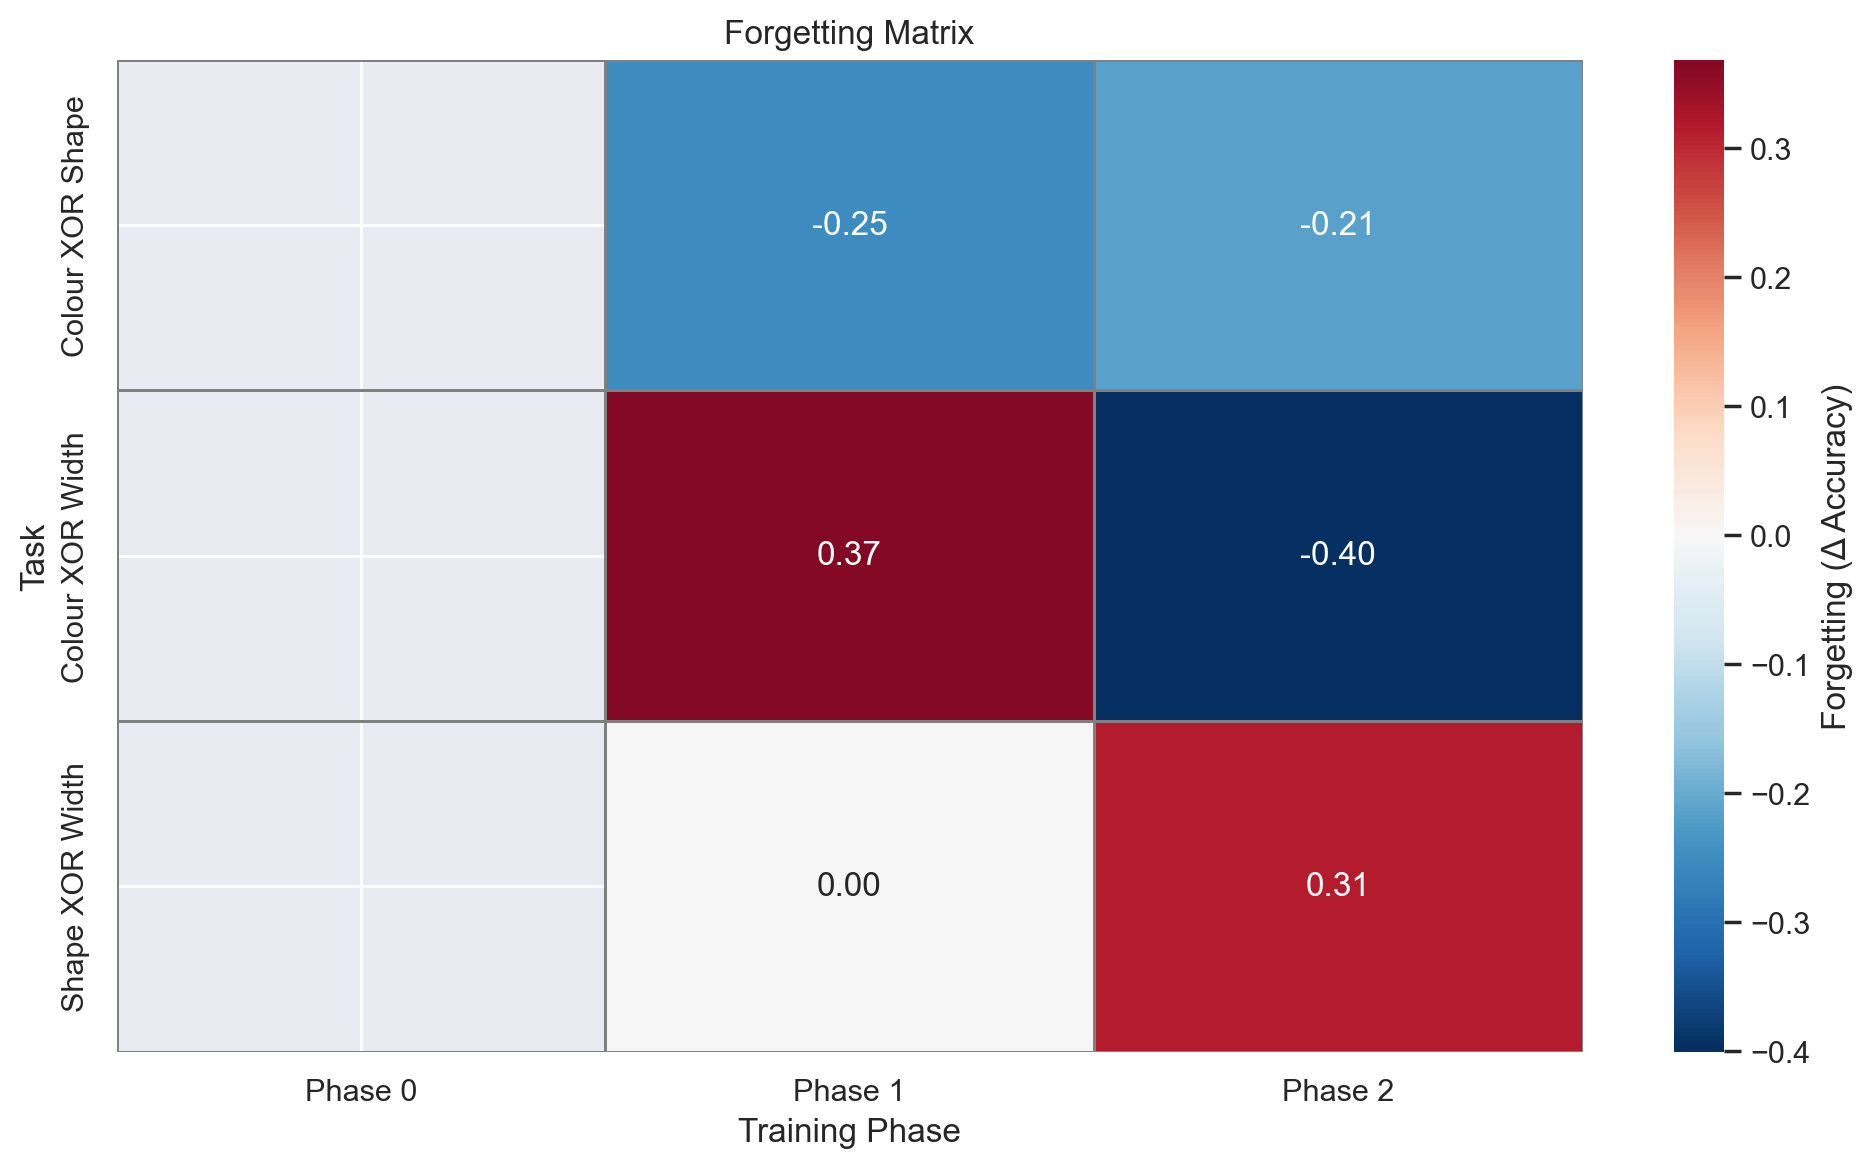

In [10]:
# Maybe useless?
forgetting, task_ids = compute_forgetting_matrix(combined_results['standard_controller'], task_sequence)
plot_forgetting_matrix(forgetting, task_ids, task_descriptions=task_descriptions)
forgetting, task_ids = compute_forgetting_matrix(combined_results['lora_controller'], task_sequence)
plot_forgetting_matrix(forgetting, task_ids, task_descriptions=task_descriptions)

In [11]:
0.72-0.49
0.34-0.28

0.06

#### LoRA

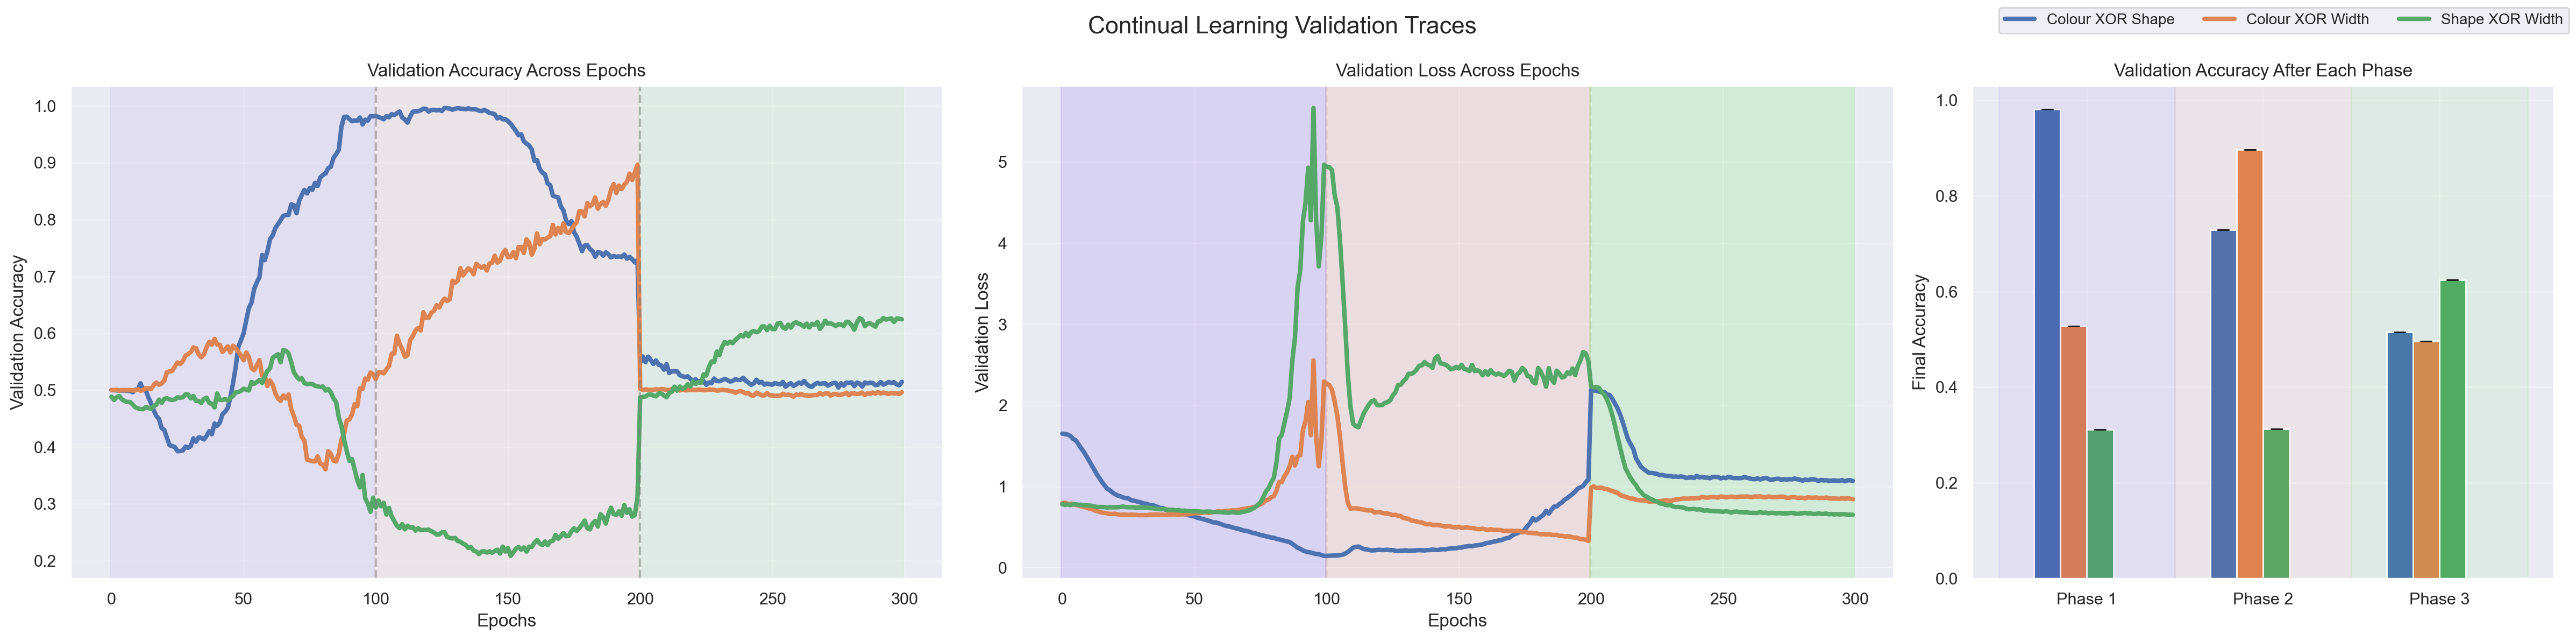

In [12]:
# Plot continual learning traces
task_sequence = [[14], [23], [27]]
plot_continual_validation_traces(
    results=combined_results['lora_controller'],
    task_sequence=task_sequence,
    task_descriptions=task_descriptions)

### 3.2 🔄 Task Switching: How Fast Can the Model Adapt to New Tasks?

We analyze the model's adaptation speed and generalization when faced with novel tasks.

#### Standard BP

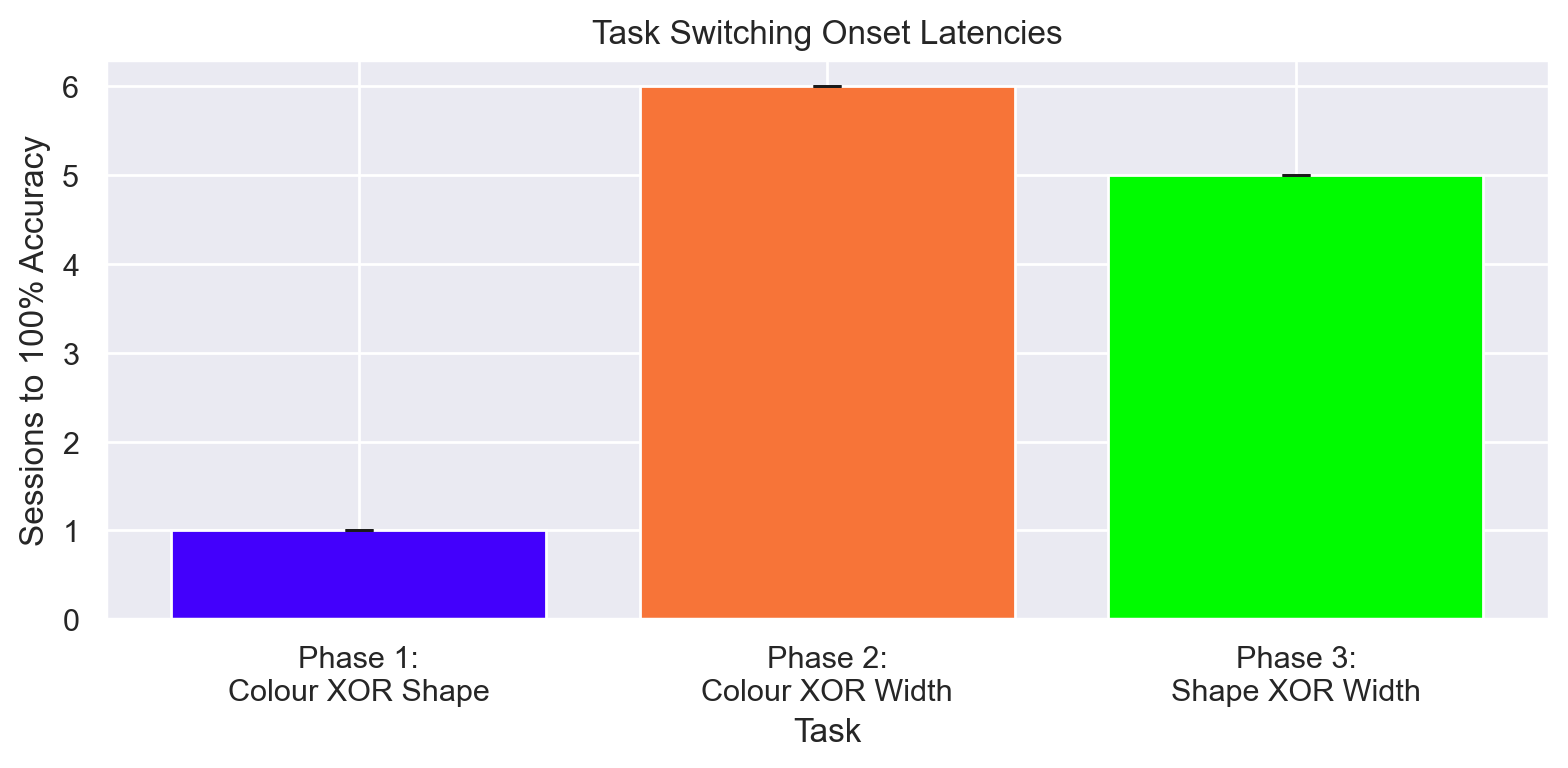

In [13]:
latencies = compute_transfer_onset_latency(combined_results['standard_controller'], task_sequence, threshold=0.9)
plot_transfer_onset_latencies(latencies, task_descriptions=task_descriptions)


#### LoRA

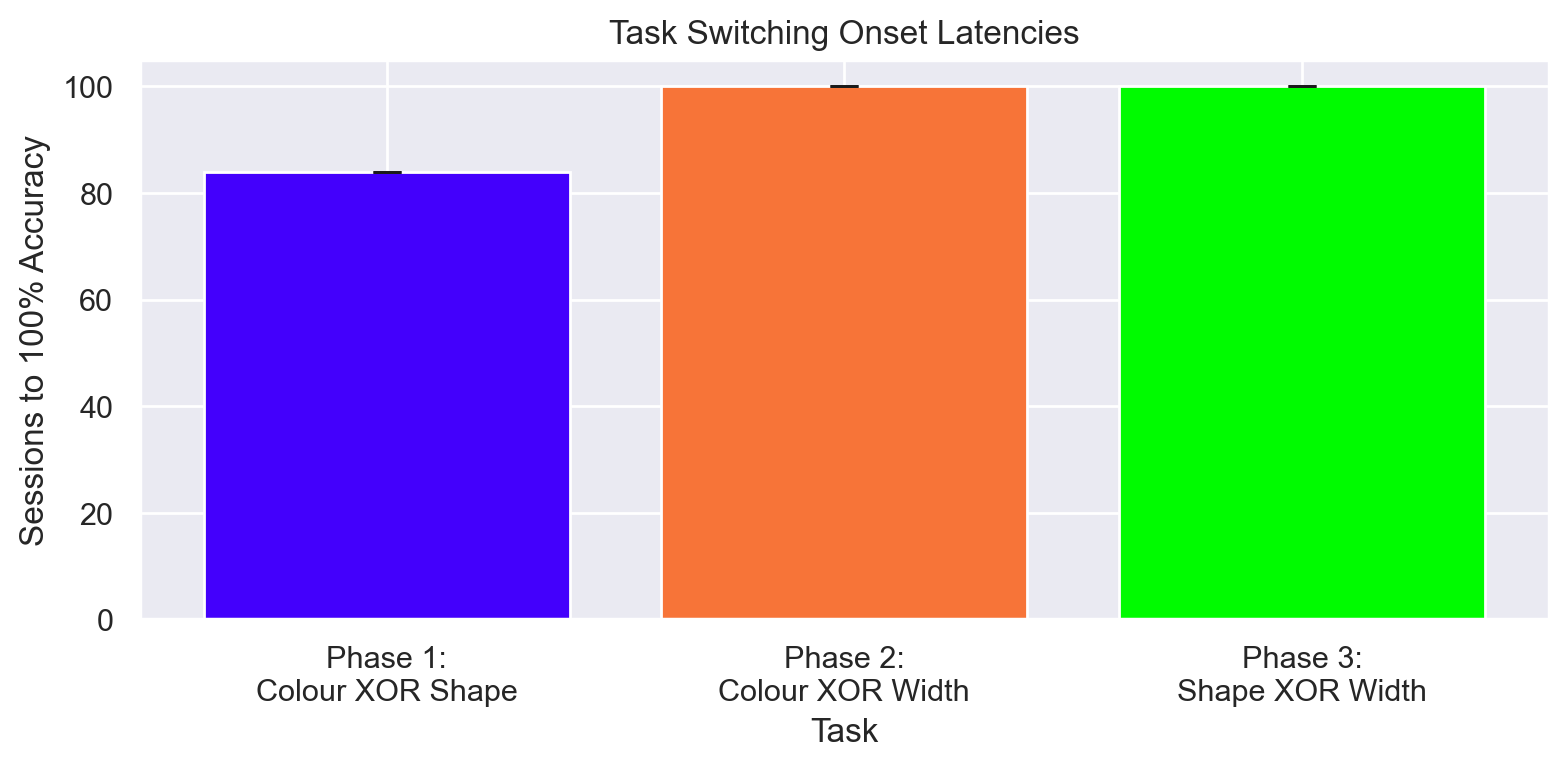

In [14]:
latencies = compute_transfer_onset_latency(combined_results['lora_controller'], task_sequence, threshold=0.9)
plot_transfer_onset_latencies(latencies, task_descriptions=task_descriptions)
